# 모델러닝 중 전처리 작업을 위해 만든 파일

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pyarrow.parquet as pq
import tqdm
import optuna
import matplotlib.font_manager as fm


# test 데이터 준비 (샘플로 train에서 분리)
from sklearn.model_selection import train_test_split

# 모델 학습 및 평가
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score


# notebook이 있는 디렉토리를 절대경로로 설정
notebook_dir = r'c:\Users\Administrator\github\Credit-Card-Segment\LGW'

# sys.path에 추가 (중복 확인)
if notebook_dir not in sys.path:
    sys.path.insert(0, notebook_dir)

# 작업 디렉토리 변경
os.chdir(notebook_dir)
from corr_dict import corr_dict

c:\Users\Administrator\miniconda3\envs\Sub\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
HOME = os.getcwd()
list_dir = os.listdir(HOME)

In [ ]:
list_dir

['1.corr.common.txt',
 '1.corr.txt',
 '2.corr.txt',
 '240_Segment.parquet',
 '3.corr.txt',
 '4.corr.txt',
 '5.corr.txt',
 '6.corr.txt',
 '7.corr.txt',
 '8.corr.txt',
 'backup',
 'catboost_info',
 'corr_dict.py',
 'corr_Name_backup.txt',
 'credit_preprocessing_month_10.parquet',
 'credit_preprocessing_month_11.parquet',
 'credit_preprocessing_month_12.parquet',
 'credit_preprocessing_month_7.parquet',
 'credit_preprocessing_month_8.parquet',
 'credit_preprocessing_month_9.parquet',
 'data',
 'Data_Analysis.ipynb',
 'Data_Analysis_Lite.ipynb',
 'Data_Analysis_Main.ipynb',
 'Data_Analysis_Sub.ipynb',
 'Data_Analysis_Sub_2.ipynb',
 'Data_Analysis_Sub_3.ipynb',
 'LGW Read me',
 'merge_data.ipynb',
 'merge_data_feedback.ipynb',
 'Segment_Correlation_Pearson',
 'Segment_Correlation_Spearman.txt',
 'test',
 '_1st_corr.txt',
 '__pycache__']

### 시작 전 준비
 - 858개라는 방대한 데이터를 가지게 됬지만, 이는 세부적인 사항을 고려하지 못할수도 있다. 따라서, 나중에 세부사항을 파악하기 위해서 따로 사용할 코드를 하나 더 만들어 놓는다.

In [ ]:
# 각 폴더명 딕셔너리
folder_name = {1:"1.회원정보", 2:"2.신용정보", 3:"3.승인매출정보", 4:"4.청구입금정보", 5:"5.잔액정보", 6:"6.채널정보", 7:"7.마케팅정보", 8:"8.성과정보"}

# 현재 디렉터리
HOME = os.getcwd()

# 폴더 리스트를 생성하고 폴더 경로들을 리스트로 저장하기
folder_list = []
for value in folder_name.values():
    folder_list.append(os.path.join(HOME, "data", "train", value))
print(len(folder_list))

# 폴더 내 파일 리스트 읽어오기
fileNameList = {}
for i in range(len(folder_list)):
    fileNameList[i+1] = os.listdir(folder_list[i])
print(fileNameList)

# 파일 경로 리스트 생성
filePathList = {}
temp = []
for i in range(len(folder_list)):
    for j in range(len(fileNameList[i+1])):
        temp.append(os.path.join(folder_list[i], fileNameList[i+1][j]))
    filePathList[i+1] = temp
    temp = []

print(filePathList)

8
{1: ['201807_train_회원정보.parquet', '201808_train_회원정보.parquet', '201809_train_회원정보.parquet', '201810_train_회원정보.parquet', '201811_train_회원정보.parquet', '201812_train_회원정보.parquet'], 2: ['201807_train_신용정보.parquet', '201808_train_신용정보.parquet', '201809_train_신용정보.parquet', '201810_train_신용정보.parquet', '201811_train_신용정보.parquet', '201812_train_신용정보.parquet'], 3: ['201807_train_승인매출정보.parquet', '201808_train_승인매출정보.parquet', '201809_train_승인매출정보.parquet', '201810_train_승인매출정보.parquet', '201811_train_승인매출정보.parquet', '201812_train_승인매출정보.parquet'], 4: ['201807_train_청구정보.parquet', '201808_train_청구정보.parquet', '201809_train_청구정보.parquet', '201810_train_청구정보.parquet', '201811_train_청구정보.parquet', '201812_train_청구정보.parquet'], 5: ['201807_train_잔액정보.parquet', '201808_train_잔액정보.parquet', '201809_train_잔액정보.parquet', '201810_train_잔액정보.parquet', '201811_train_잔액정보.parquet', '201812_train_잔액정보.parquet'], 6: ['201807_train_채널정보.parquet', '201808_train_채널정보.parquet', '201809_train_채널정보.parquet',

In [ ]:
pd.read_parquet(filePathList[1][0], engine = "fastparquet")

기준년월            ID  남녀구분코드     연령 Segment  회원여부_이용가능  회원여부_이용가능_CA  \
0       201807  TRAIN_000000       2    40대       D          1             1   
1       201807  TRAIN_000001       1    30대       E          1             1   
2       201807  TRAIN_000002       1    30대       C          1             1   
3       201807  TRAIN_000003       2    40대       D          1             1   
4       201807  TRAIN_000004       2    40대       E          1             1   
...        ...           ...     ...    ...     ...        ...           ...   
399995  201807  TRAIN_399995       2  70대이상       E          1             1   
399996  201807  TRAIN_399996       2    50대       D          1             1   
399997  201807  TRAIN_399997       1    30대       C          1             1   
399998  201807  TRAIN_399998       1    40대       E          1             1   
399999  201807  TRAIN_399999       2    40대       E          1             1   

        회원여부_이용가능_카드론  소지여부_신용  소지카드수_유효_신용  ...  할인금액_제휴연회비_B0M  \
0                   0        1            1  ...               0   
1                   1        1            1  ...               0   
2                   0        1            1  ...               0   
3                   0        1            2  ...               0   
4                   1        1            1  ...               0   
...               ...      ...          ...  ...             ...   
399995              1        1            1  ...               0   
399996              1        1            1  ...               0   
399997              0        1            1  ...               0   
399998              1        1            1  ...               0   
399999              0        1            1  ...               0   

        청구금액_기본연회비_B0M  청구금액_제휴연회비_B0M  상품관련면제카드수_B0M  임직원면제카드수_B0M  \
0                    0               0             0개            0개   
1                    0               0             0개            0개   
2                    0               0             0개            0개   
3                    0               0             0개            0개   
4                    0               0             0개            0개   
...                ...             ...            ...           ...   
399995               0               0             0개            0개   
399996               0               0             0개            0개   
399997               0               0             0개            0개   
399998               0               0             0개            0개   
399999               0               0             0개            0개   

        우수회원면제카드수_B0M  기타면제카드수_B0M  카드신청건수  Life_Stage  최종카드발급경과월  
0                  0개           0개       0     자녀성장(2)         22  
1                  0개           0개       0     자녀성장(1)         18  
2                  0개           0개       0       자녀출산기         20  
3                  0개           0개       1     자녀성장(2)         17  
4                  0개           0개       1     자녀성장(1)         15  
...               ...          ...     ...         ...        ...  
399995             0개           0개       0        노년생활         34  
399996             0개           0개       0     자녀성장(2)         19  
399997             0개           0개       0       자녀출산기         13  
399998             0개           0개       0     자녀성장(1)         22  
399999             0개           0개       0     자녀성장(1)         13  

[400000 rows x 78 columns]

In [ ]:
# list에 나중에 불러올 파일들을 저장하기
df_list = list(filter(lambda x: x.endswith('.parquet'), list_dir))
df_list = sorted(df_list, key=lambda x: int(re.search(r'\d+', x).group()))
print(df_list)

['credit_preprocessing_month_7.parquet', 'credit_preprocessing_month_8.parquet', 'credit_preprocessing_month_9.parquet', 'credit_preprocessing_month_10.parquet', 'credit_preprocessing_month_11.parquet', 'credit_preprocessing_month_12.parquet', '240_Segment.parquet']


In [ ]:
# # 최적화해둔 전체 파일 불러오기
# option = 0 # 0 : 하나만 불러오기, 1 : 데이터 전체를 합병해서 불러오기
# if option == 0:
#     df = pd.read_parquet(df_list[0], engine='fastparquet')
# if option == 1:
#     df = pd.read_parquet(df_list[0], engine = "fastparquet")
#     for i in range(1, 6):
#         temp = pd.read_parquet(df_list[i], engine = "fastparquet")
#         df = pd.concat([df, temp])
# df
        

In [ ]:
# 메모리를 32비트로 변환
def optimize_memory(df):
    for col in df.select_dtypes(include=['number']).columns:
        # 정수형은 가능한 가장 작은 타입으로 (int8, int16 등)
        if df[col].dtype == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')
        # 실수형은 float32로
        elif df[col].dtype == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
    return df

In [ ]:
# 240만개의 파일을 이어 붙이기
# 각 폴더에 들어있는 파일들 중 같은 달의 열을 모두 합침
def load_cat(i):
    df = optimize_memory(pd.read_parquet(filePathList[i][0]))
    for j in range(1,6):
        df = pd.concat([df, optimize_memory(pd.read_parquet(filePathList[i][j]))])
    return df

# 공통된 쓸모없는 column 제거 함수=
def drop_useless(df):
    df = df.drop(columns = ["기준년월", "ID"])
    return df
# target인 Segment가 없을시 Segment 추가
def add_target(df):# target이 존재하지 않는 df, target명(문자열)
    df = pd.merge(pd.read_parquet(filePathList[1][0])[["기준년월", "ID", "Segment"]], df, on = ["기준년월","ID"],how = "left")
    return df

def make_df(i):
    df = load_cat(i)
    # i 가 1보다 크고 1보다 작을때 사용
    if (i > 1) & (i <= 6): df = add_target(df)
    elif i == 1: return drop_useless(df)
    else: print("숫자가 아니거나 할당 없는 카테고리입니다.")
    return drop_useless(df)

# 데이터프레임에서 파라미터를 입력하면 그 파라미터가 포함된 column들을 가져와 새로운 데이터프레임을 반환함
# 연관성 있는 column들을 얻어오기 위해서 사용한다.
def find_R(df, param1):
    columns = list(df.columns)
    new_columns = []
    for column in columns:
        if param1 in column:
            new_columns.append(column)
    return pd.DataFrame(df[new_columns])

In [ ]:
def corr_maker(df, filename= False, method = "pearson",target = False, map = False):

    # 1. 데이터 복사 (원본 데이터프레임 보호)    
    temp_df = df.copy()
    if map:
        mapping = {'A': 4, 'B': 3, 'C': 2, 'D': 1, 'E': 0}
        temp_df["Segment"] = temp_df["Segment"].map(mapping)

    # 2. 문자열 컬럼만 골라내기
    obj_cols = temp_df.select_dtypes(include=['object']).columns

    # 3. 문자열 컬럼만 factorize 적용
    for col in obj_cols:
        temp_df[col] = pd.factorize(temp_df[col])[0]

    # 4. 전체 상관관계 계산 (스피어먼 방식)
    corr_matrix = temp_df.corr(method = method)# method = spearman

    # 5. 특정 컬럼('Segment') 기준 추출
    target_col = "Segment"
    if target_col in corr_matrix.columns:
        target_corr = corr_matrix[target_col].sort_values(ascending=False)
        result_series = target_corr.drop(target_col)
        
        # --- [추가된 부분: 파일 저장] ---
        if filename:
            with open(filename, 'w', encoding='utf-8') as f:
                f.write(f"[{target_col}] 기준 상관관계 순위 (Spearman):\n")
                f.write("-" * 50 + "\n")
                f.write(result_series.to_string())
                f.write("\n" + "-" * 50)
                print(f"결과가 {filename}에 저장되었습니다.")
        print(result_series)
        # -------------------------------
    else:
        print(f"'{target_col}' 컬럼이 데이터에 없습니다.")
# 만들어 놓은 corr파일을 읽어오는 함수
def read_corr(filename = False):
    if filename:
        f = open(filename, "r")
        Segment_corr = []
        temp = f.readline()
        temp = f.readline()

        while True:
            temp = f.readline()
            temp = [temp.split()[0], float(temp.split()[-1])]
            if str(temp[1]) == "nan":
                break
            else:
                Segment_corr.append(temp)
        f.close()
        return Segment_corr
    else:
        print("Please Enter filename")
# 주의 : 상관관계들이 모두 절대값이 된다.
# 상관관계를 정렬하는 함수
def sort_corr(corrs):
    new_corr = []
    for corr in corrs:
        new_corr.append([corr[0], abs(corr[1])])   
    new_corr = sorted(new_corr, key = lambda x:x[1], reverse = True)
    return new_corr

# 일정치 이상의 corr만 남기는 함수
def filter_high_corr(corrs, filter = 0.2):
    new_corr = []
    for corr in corrs:
        if (corr[1] >= filter) | (corr[1]<= -filter):
            new_corr.append(corr)
    return new_corr

In [ ]:
def read_corr(filename=False):
    if filename:
        f = open(filename, "r", encoding='utf-8')
        Segment_corr = []
        temp = f.readline()
        temp = f.readline()

        while True:
            temp = f.readline()
            # 빈 줄이거나 줄 끝에 도달한 경우 루프 탈출
            if not temp or not temp.strip():
                break
            
            split_temp = temp.split()
            # split 결과가 충분한 요소를 가지고 있는지 확인
            if len(split_temp) < 2:
                break
            
            try:
                temp = [split_temp[0], float(split_temp[-1])]
                if str(temp[1]) == "nan":
                    break
                else:
                    Segment_corr.append(temp)
            except ValueError:
                # float 변환 실패 시 루프 탈출
                break
        
        f.close()
        return Segment_corr
    else:
        print("Please Enter filename")

In [ ]:
# 리스트에 추가하는 함수
def add_list(origin , columns):
    if(type(columns) == list):
        for column in columns:
            origin.append(column)
    elif type(columns) == str:
        origin.append(columns)

In [ ]:
# 0과 1로 이루어진 데이터들 중, 상대적으로 부족한 A, B에 대해서 확실히 평가를 끌어내 줄 수 있지 않을까 싶어서 가져온 자료
def plot_segment_comparison(df, column):
    """
    Segment와 지정된 column의 관계를 stacked bar chart와 heatmap으로 시각화
    1행 2열 subplot
    
    Parameters:
    -----------
    df : DataFrame
        데이터프레임
    column : str
        비교할 column 이름 (예: "회원여부_연체")
    """
    df_reset = df.reset_index(drop=True)
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False
    sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus": False},
        style='darkgrid')
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # 1. Stacked Bar Chart (왼쪽)
    crosstab_pct = pd.crosstab(df_reset["Segment"], df_reset[column], normalize='index') * 100
    crosstab_pct.plot(kind='bar', stacked=True, ax=axes[0], color=['#2ecc71', '#e74c3c'])
    axes[0].set_title(f"Segment별 {column} 비율 (100%)", fontsize=12, fontweight='bold')
    axes[0].set_xlabel("Segment (0=E, 1=D, 2=C, 3=B, 4=A)")
    axes[0].set_ylabel("비율 (%)")
    axes[0].legend(title=column, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 2. HeatMap (오른쪽)
    crosstab = pd.crosstab(df_reset["Segment"], df_reset[column])
    sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1], cbar_kws={'label': '빈도'})
    axes[1].set_title(f"Segment별 {column} 매트릭스", fontsize=12, fontweight='bold')
    axes[1].set_xlabel(column)
    axes[1].set_ylabel("Segment (0=E, 1=D, 2=C, 3=B, 4=A)")
    
    plt.tight_layout()
    plt.show()

# 사용 예시
# plot_segment_comparison(df, "회원여부_연체")
# plot_segment_comparison(df, "가입통신회사코드")

In [ ]:
df = make_df(1)
df

남녀구분코드     연령 Segment  회원여부_이용가능  회원여부_이용가능_CA  회원여부_이용가능_카드론  \
0            2    40대       D          1             1              0   
1            1    30대       E          1             1              1   
2            1    30대       C          1             1              0   
3            2    40대       D          1             1              0   
4            2    40대       E          1             1              1   
...        ...    ...     ...        ...           ...            ...   
399995       2  70대이상       E          1             1              1   
399996       2    50대       D          1             1              1   
399997       1    30대       C          1             1              0   
399998       1    40대       E          1             1              1   
399999       2    40대       E          1             1              0   

        소지여부_신용  소지카드수_유효_신용  소지카드수_이용가능_신용   입회일자_신용  ...  할인금액_제휴연회비_B0M  \
0             1            1              1  20130101  ...               0   
1             1            1              1  20170801  ...               0   
2             1            1              1  20080401  ...               0   
3             1            2              2  20160501  ...               0   
4             1            1              1  20180601  ...               0   
...         ...          ...            ...       ...  ...             ...   
399995        1            1              1  20010701  ...               0   
399996        1            1              1  20170701  ...               0   
399997        1            1              1  20090501  ...               0   
399998        1            1              1  20130101  ...               0   
399999        1            1              1  20180501  ...               0   

        청구금액_기본연회비_B0M  청구금액_제휴연회비_B0M  상품관련면제카드수_B0M  임직원면제카드수_B0M  \
0                    0               0             0개            0개   
1                    0               0             0개            0개   
2                    0               0             0개            0개   
3                    0               0             0개            0개   
4                    0               0             0개            0개   
...                ...             ...            ...           ...   
399995               0               0             0개            0개   
399996               0               0             0개            0개   
399997               0               0             0개            0개   
399998               0               0             0개            0개   
399999               0               0             0개            0개   

        우수회원면제카드수_B0M  기타면제카드수_B0M  카드신청건수 Life_Stage  최종카드발급경과월  
0                  0개           0개       0    자녀성장(2)         22  
1                  0개           0개       0    자녀성장(1)         18  
2                  0개           0개       0      자녀출산기         20  
3                  0개           0개       1    자녀성장(2)         17  
4                  0개           0개       1    자녀성장(1)         15  
...               ...          ...     ...        ...        ...  
399995             0개           0개       0       노년생활         39  
399996             0개           0개       0    자녀성장(2)         24  
399997             0개           0개       0      자녀출산기         18  
399998             0개           0개       0    자녀성장(1)         27  
399999             0개           0개       0    자녀성장(1)         18  

[2400000 rows x 76 columns]

In [15]:
# Segment 매핑
mapping = {"E":0, "D":1, "C":2, "B":3, "A":4}
df["Segment"] = df["Segment"].map(mapping)

In [16]:
# 모든 값이 같은 칼럼 찾기
constant_columns = []

for col in df.columns:
    # 결측치를 제외하고 unique 값의 개수가 1개인 칼럼 찾기
    unique_values = df[col].dropna().nunique()
    if unique_values == 1:
        constant_columns.append(col)
        print(f"'{col}': {df[col].dropna().iloc[0]}")

print(f"\n=== 결과 ===")
print(f"모든 값이 같은 칼럼 개수: {len(constant_columns)}")
print(f"\n칼럼 목록:")
print(constant_columns)

# (선택사항) 이러한 칼럼들 삭제
if len(constant_columns) > 0:
    print(f"\n다음 칼럼들을 삭제하시겠습니까?")
    df = df.drop(constant_columns, axis=1)
    print("삭제 완료!")

# 용도가 겹치거나 필요없는 column 제거
# 직장시도명 -> 거주시도명과 거의 같음 + 결측치 있음
_drop1 = ["직장시도명", "입회일자_신용", "최종카드발급일자"]
df = df.drop(_drop1, axis=1)

# 피쳐엔지니어링을 위해 전처리하고 필요없어진 데이터
_drop2 = []

'이용카드수_체크_가족': 0
'이용금액_R3M_체크_가족': 0
'연회비할인카드수_B0M': 0
'할인금액_기본연회비_B0M': 0
'할인금액_제휴연회비_B0M': 0
'상품관련면제카드수_B0M': 0개
'임직원면제카드수_B0M': 0개
'우수회원면제카드수_B0M': 0개
'기타면제카드수_B0M': 0개

=== 결과 ===
모든 값이 같은 칼럼 개수: 9

칼럼 목록:
['이용카드수_체크_가족', '이용금액_R3M_체크_가족', '연회비할인카드수_B0M', '할인금액_기본연회비_B0M', '할인금액_제휴연회비_B0M', '상품관련면제카드수_B0M', '임직원면제카드수_B0M', '우수회원면제카드수_B0M', '기타면제카드수_B0M']

다음 칼럼들을 삭제하시겠습니까?
삭제 완료!


In [17]:
# 가입 통신 회사코드 매핑
# 6만개의 결측치 존재, 중간값으로 하는게 일단 좋다고 하는데 일단 스톱
temp_mapping = {"L사":0, "K사":1, "S사":2}
df["가입통신회사코드"] = df["가입통신회사코드"].map(temp_mapping)
df[["가입통신회사코드", "Segment"]].corr()
# 제거 가능할 정도로 아주 낮은 수치의 상관관계를 가지고 있다. 오히려 방해될듯
# 따라서 결측치도 채우지 않고 버린다.
add_list(_drop2, "가입통신회사코드")

# 거주시도명
df["거주시도명"].unique()
df["거주시도명"] = pd.factorize(df["거주시도명"])[0]
df[["거주시도명", "Segment"]].corr()
add_list(_drop2, "거주시도명")
# 매우 낮은 상관관계를 가지고 있으며, 이딴게... 점수? 싶을정도로 점수가 낮다.
df["_1순위신용체크구분"].value_counts()


_1순위신용체크구분
신용    2295461
체크      76589
Name: count, dtype: int64

In [18]:
df.columns

Index(['남녀구분코드', '연령', 'Segment', '회원여부_이용가능', '회원여부_이용가능_CA', '회원여부_이용가능_카드론',
       '소지여부_신용', '소지카드수_유효_신용', '소지카드수_이용가능_신용', '입회경과개월수_신용', '회원여부_연체',
       '이용거절여부_카드론', '동의여부_한도증액안내', '수신거부여부_TM', '수신거부여부_DM', '수신거부여부_메일',
       '수신거부여부_SMS', '가입통신회사코드', '탈회횟수_누적', '최종탈회후경과월', '탈회횟수_발급6개월이내',
       '탈회횟수_발급1년이내', '거주시도명', '마케팅동의여부', '유효카드수_신용체크', '유효카드수_신용',
       '유효카드수_신용_가족', '유효카드수_체크', '유효카드수_체크_가족', '이용가능카드수_신용체크', '이용가능카드수_신용',
       '이용가능카드수_신용_가족', '이용가능카드수_체크', '이용가능카드수_체크_가족', '이용카드수_신용체크',
       '이용카드수_신용', '이용카드수_신용_가족', '이용카드수_체크', '이용금액_R3M_신용체크', '이용금액_R3M_신용',
       '이용금액_R3M_신용_가족', '이용금액_R3M_체크', '_1순위카드이용금액', '_1순위카드이용건수',
       '_1순위신용체크구분', '_2순위카드이용금액', '_2순위카드이용건수', '_2순위신용체크구분',
       '최종유효년월_신용_이용가능', '최종유효년월_신용_이용', '보유여부_해외겸용_본인', '이용가능여부_해외겸용_본인',
       '이용여부_3M_해외겸용_본인', '보유여부_해외겸용_신용_본인', '이용가능여부_해외겸용_신용_본인',
       '이용여부_3M_해외겸용_신용_본인', '연회비발생카드수_B0M', '기본연회비_B0M', '제휴연회비_B0M',
       '청구금액_기본연회비_B0M', '청구금액_제휴연회비_B0M', '카드신청건수', 'Life_St

In [19]:
# 신용 체크 구분
print("_1순위신용체크구분의 결측치 : {}".format(df["_1순위신용체크구분"].isna().sum()))
print(df["_1순위신용체크구분"].value_counts())
print("\n_2순위신용체크구분의 결측치 : {}".format(df["_2순위신용체크구분"].isna().sum()))
print(df["_2순위신용체크구분"].value_counts())
# 결측치가 있다곤 하지만, 1순위 신용, 2순위 신용이 되어있는곳도있기때문에, 먼저 각 데이터 프레임의 결측치를 확인하고 처리한다.
df.select_dtypes(include="str").isnull().sum().sort_values()
df[["_1순위신용체크구분","_2순위신용체크구분"]].loc[df["_1순위신용체크구분"].isnull() & df["_2순위신용체크구분"].isnull()]
temp = df[["Segment","유효카드수_신용체크", '소지카드수_유효_신용', '소지카드수_이용가능_신용', '소지카드수_이용가능_신용', '이용가능카드수_신용체크', '이용가능카드수_신용', '이용가능카드수_신용_가족', '이용가능카드수_체크',
       '이용가능카드수_체크_가족',"_1순위신용체크구분","_2순위신용체크구분"]].loc[df["_1순위신용체크구분"].isnull() & df["_2순위신용체크구분"].notna()]
# 각 결측치를 확인한 결과, _1순위신용체크구분에서 null인 부분과 _2순위 신용체크부분 모두 null인 경우가 대부분이다.  
# 그런데 이건 그냥 궁금해서 돌려보는건데, 1순위 신용체크 구분이 0인데 어케 했냐...
# 어차피 표본량에 거의 못미칠정도로 적으니(286) 일단 무시하자.
df[["_1순위신용체크구분","_2순위신용체크구분"]].loc[df["_1순위신용체크구분"].isnull() & df["_2순위신용체크구분"].isnull()].info()# 27664개의 데이터
# df["유효카드수_신용체크"].loc[].value_counts()

_1순위신용체크구분의 결측치 : 27950
_1순위신용체크구분
신용    2295461
체크      76589
Name: count, dtype: int64

_2순위신용체크구분의 결측치 : 958115
_2순위신용체크구분
신용    873447
체크    568438
Name: count, dtype: int64
<class 'pandas.DataFrame'>
Index: 27664 entries, 15 to 399943
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   _1순위신용체크구분  0 non-null      str  
 1   _2순위신용체크구분  0 non-null      str  
dtypes: str(2)
memory usage: 655.1 KB


In [20]:
df["_1순위신용체크구분"] = pd.factorize(df["_1순위신용체크구분"])[0]

In [21]:
# 단순히 신용체크 구분만으로 알기 어려운건 둘째치고, 상관관계를 계산해보자

df[["Segment", "_1순위신용체크구분"]].corr()

Segment  _1순위신용체크구분
Segment     1.00000    -0.01209
_1순위신용체크구분 -0.01209     1.00000

In [22]:
find_R(df,"체크")
# 1. 값이 다른 행만 보기 (가장 유용함)
df[df["유효카드수_신용체크"] != df["이용가능카드수_신용체크"]][['유효카드수_신용체크', '이용가능카드수_신용체크']]


유효카드수_신용체크  이용가능카드수_신용체크
9                2             1
17               3             2
30               1             0
41               2             1
44               3             2
...            ...           ...
399961           3             2
399975           4             3
399981           2             1
399990           1             0
399992           1             0

[278701 rows x 2 columns]

In [23]:
df.columns
df.select_dtypes(include="str")

연령 _2순위신용체크구분 연회비발생카드수_B0M Life_Stage
0         40대         체크           0개    자녀성장(2)
1         30대        NaN           0개    자녀성장(1)
2         30대         체크           0개      자녀출산기
3         40대         체크           0개    자녀성장(2)
4         40대         체크           0개    자녀성장(1)
...       ...        ...          ...        ...
399995  70대이상         체크           0개       노년생활
399996    50대        NaN           0개    자녀성장(2)
399997    30대        NaN           0개      자녀출산기
399998    40대        NaN           0개    자녀성장(1)
399999    40대         신용           0개    자녀성장(1)

[2400000 rows x 4 columns]

In [24]:
temp_mapping = {"20대":20, "30대":30, "40대":40, "50대":50, "60대":60, "70대이상":70}
df["연령"] = df["연령"].map(temp_mapping)

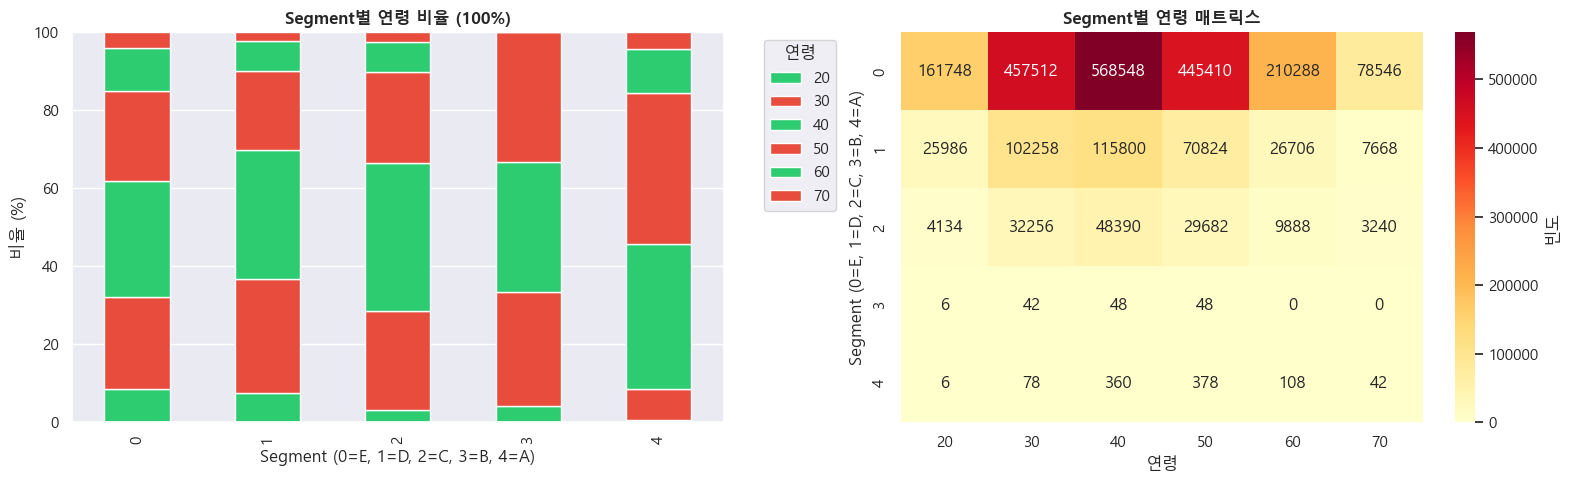

In [25]:
plot_segment_comparison(df, "연령")

In [26]:
add_list(_drop2, "연령")

- 사실 높은등급일 수록 높은 나잇대의 연령이 많거나 이런 상관관계를 찾아볼까 했지만, 그런 관계는 딱히 없어보인다.
- 실제 사용하기엔 부적합한 것으로 보인다.

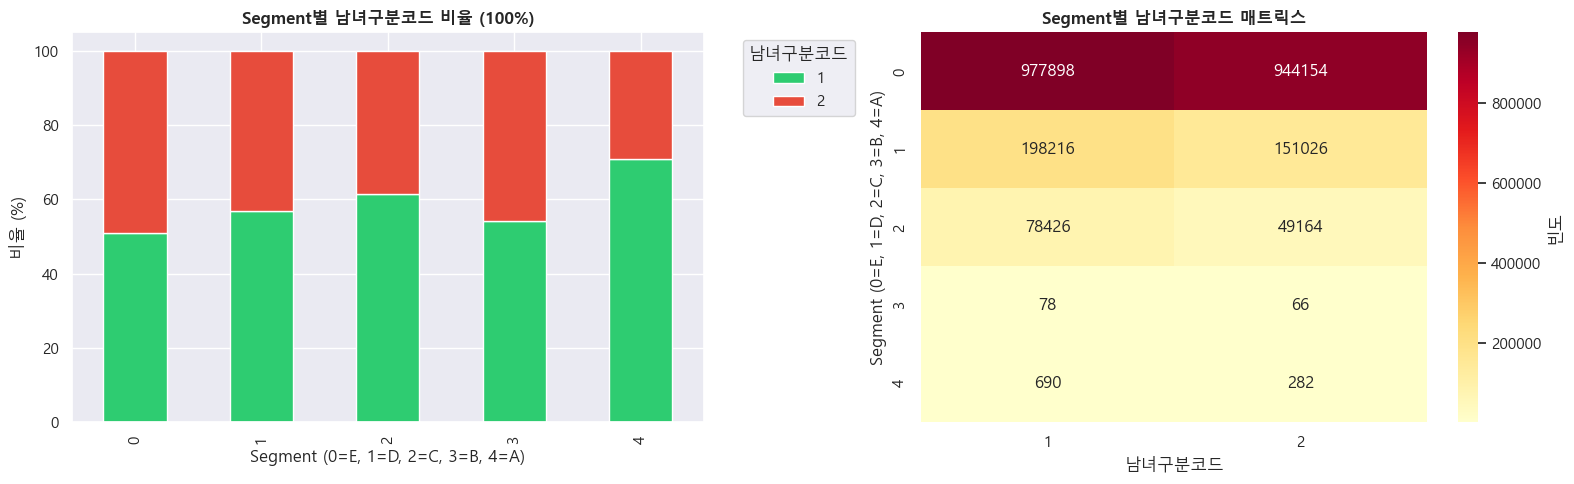

In [27]:
plot_segment_comparison(df, "남녀구분코드")

In [28]:
add_list(_drop2, "남녀구분코드")

- 상관관계가 거의 없는것으로 보이며, 성별이 Segment 구분에는 딱히 영향을 미치진 않는것으로 보인다.

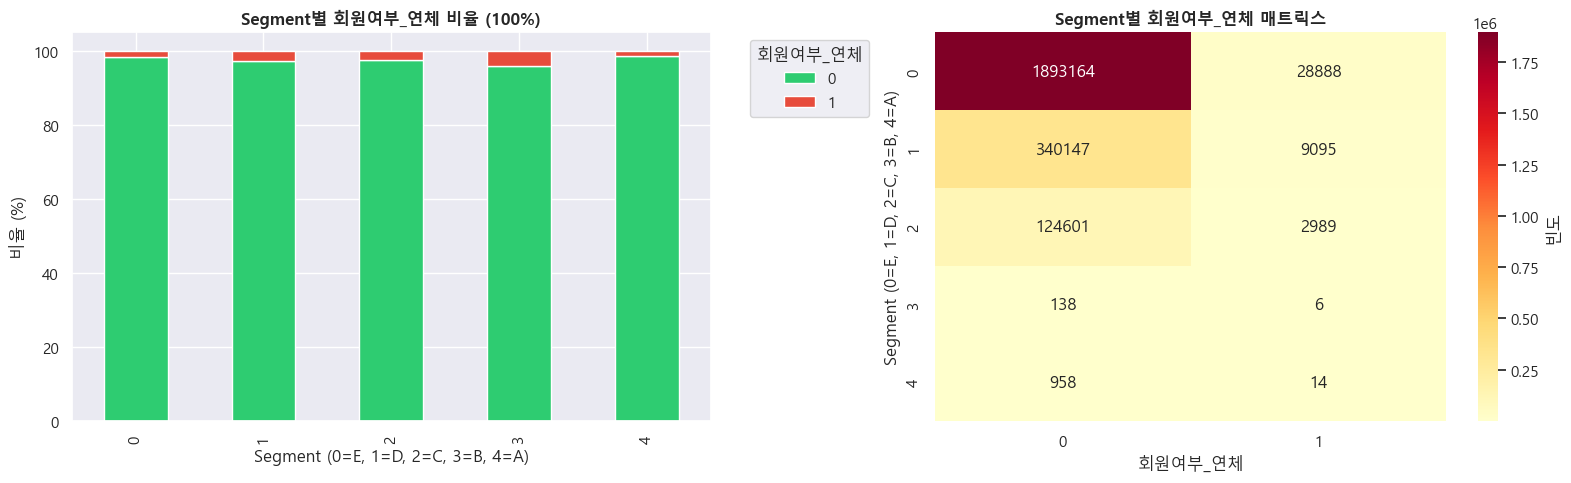

In [29]:
plot_segment_comparison(df, "회원여부_연체")

- 연체여부를 통해 A, B를 골라낼 수 있지 않을까 했는데, 비율로 따져보면 연체여부로는 따질 수 있지 않았다.
- 다만, 연체여부는 상당히 중요한 값인데다가 다른 폴더에서 들어있을 확률이 높으므로, 나중에 다른 폴더를 확인하여 연체에 관한 데이터를 조사하자.

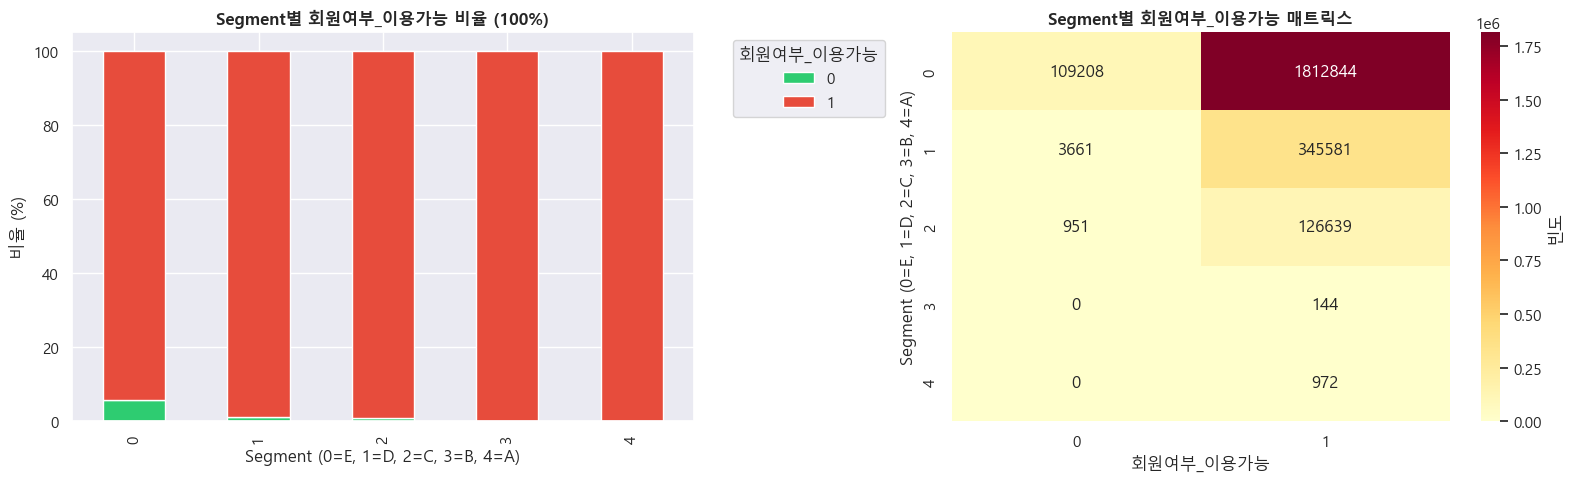

In [30]:
plot_segment_comparison(df, "회원여부_이용가능")

- 이용가능 여부는 확실하게 A, B를 걸러내고 있다. 이를 이용하면 안그래도 적은 표본의 A, B에 대해서 높은 점수를 낼 수 있지 않을까?

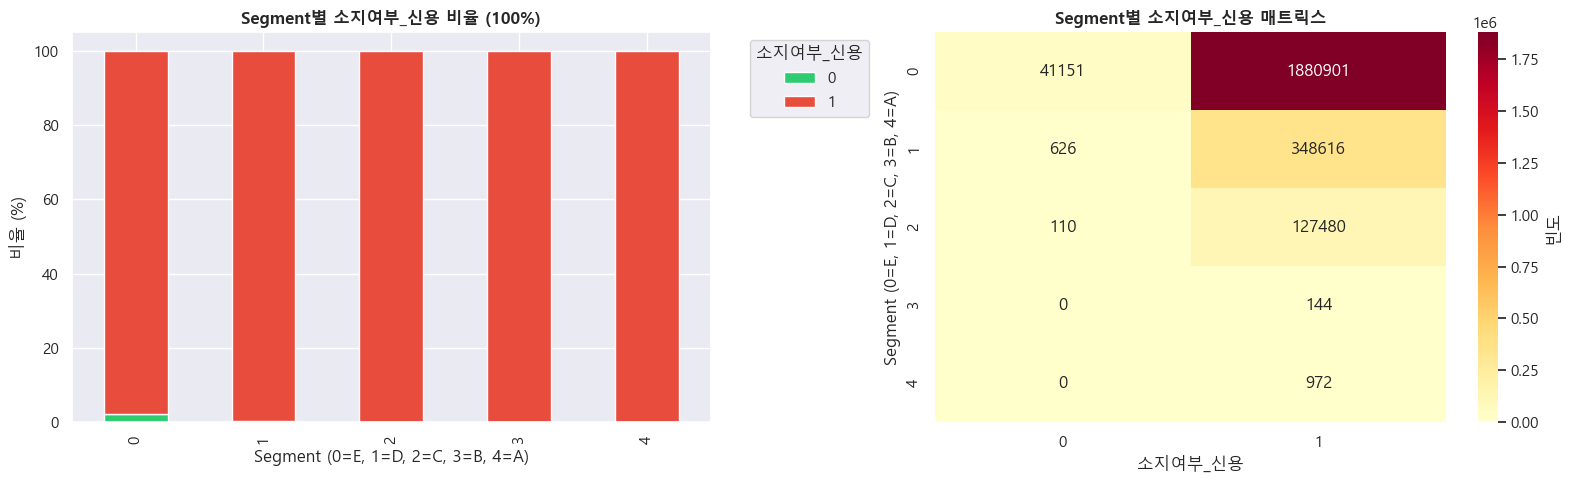

In [31]:
plot_segment_comparison(df, "소지여부_신용")

In [32]:
add_list(_drop2, "소지여부_신용")

- 소지여부 신용의 경우, 회원여부_이용가능보다 걸러낼 수 있는 방법이 적고, 다른 것들과 연계하여 사용하기 애매하며, 없는 사람들의 수가 매우 적기 때문에 삭제한다.

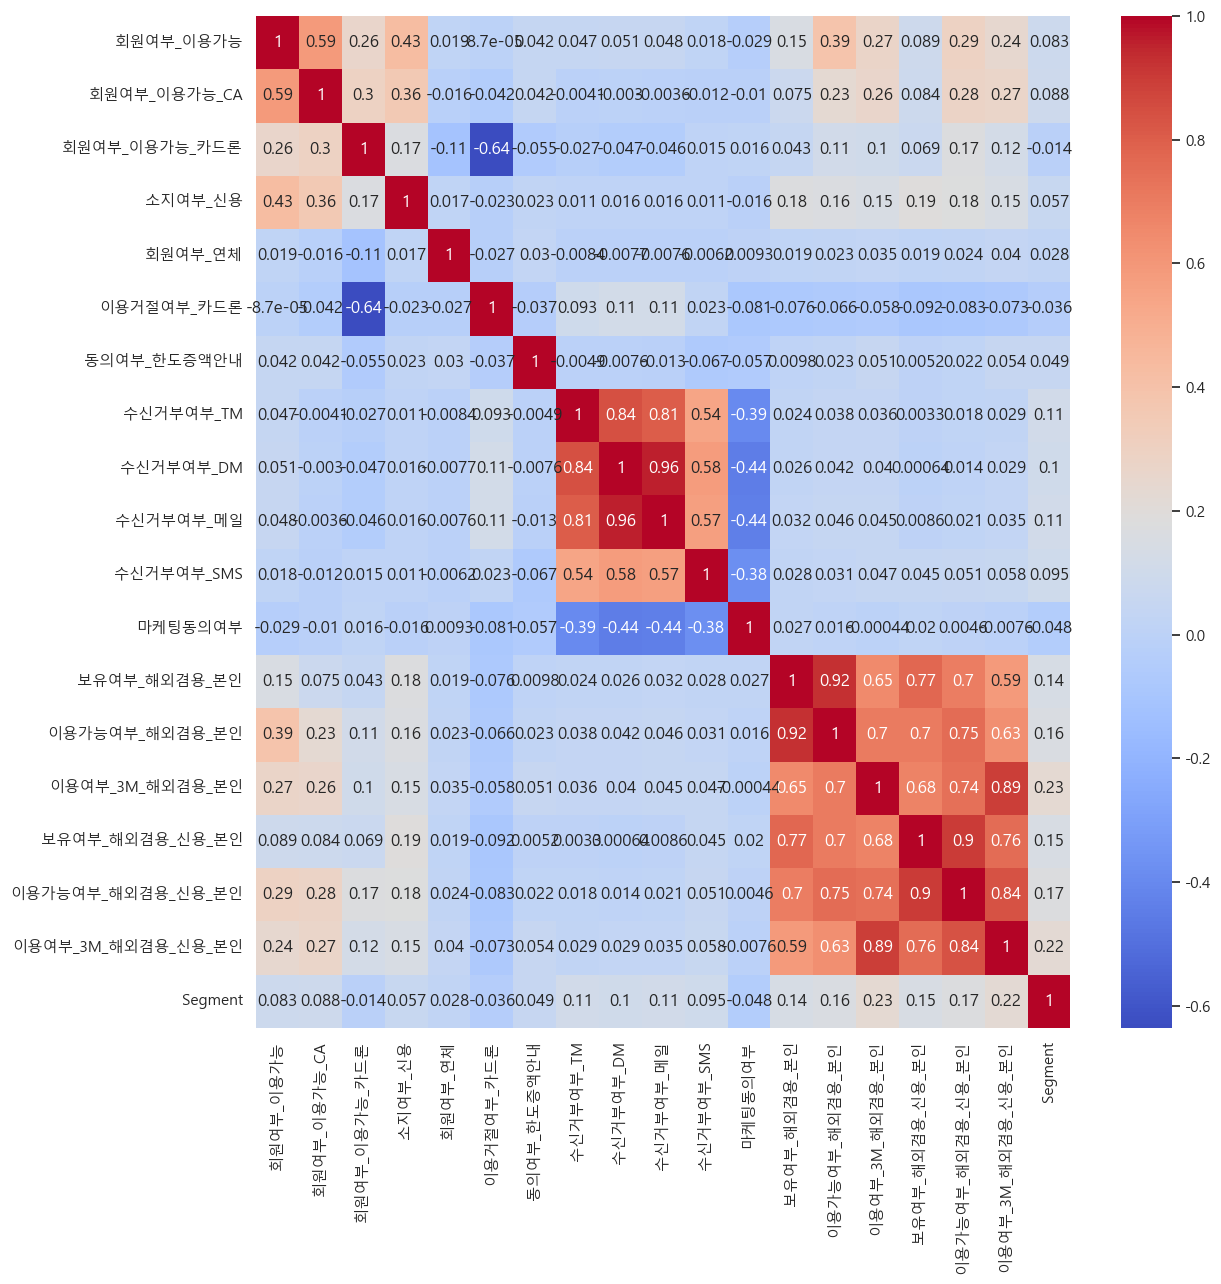

In [33]:
result_df = pd.concat([find_R(df, "여부"), df[["Segment"]]], axis=1)
plt.figure(figsize=(13, 13))
sns.heatmap(result_df.corr(), annot=True, cmap='coolwarm')
plt.tight_layout()
plt.show()

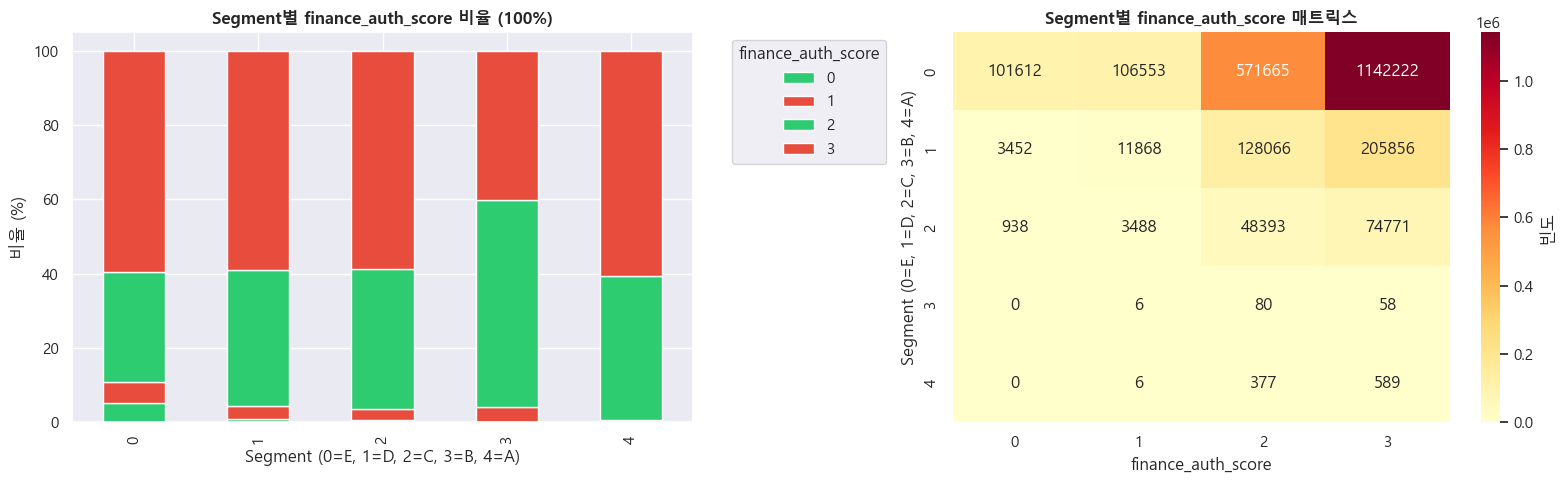

finance_auth_score   Segment
finance_auth_score            1.000000  0.050415
Segment                       0.050415  1.000000

In [34]:
df['finance_auth_score'] = (
    (df['회원여부_이용가능'] == 1).astype(int) + 
    (df['회원여부_이용가능_CA'] == 1).astype(int)+ 
    (df['회원여부_이용가능_카드론'] == 1).astype(int)
)
_drop2.append("회원여부_이용가능")
_drop2.append("회원여부_이용가능_CA")
_drop2.append("회원여부_이용가능_카드론")
plot_segment_comparison(df, "finance_auth_score")
df[["finance_auth_score", "Segment"]].corr()

- 회원여부를 이용하여 점수제로 분할하여 A, B와 C, D, E 그룹을 분할이 가능하다.
- 비율로 봤을때 각 세그먼트 별로 큰 차이는 없어보이지만 중요한건 1단계 이후가 거의 없다는 점에서 B의 경우 

In [35]:
find_R(df, "여부")

회원여부_이용가능  회원여부_이용가능_CA  회원여부_이용가능_카드론  소지여부_신용  회원여부_연체  이용거절여부_카드론  \
0               1             1              0        1        0           0   
1               1             1              1        1        0           0   
2               1             1              0        1        0           0   
3               1             1              0        1        0           0   
4               1             1              1        1        0           0   
...           ...           ...            ...      ...      ...         ...   
399995          1             1              1        1        0           0   
399996          1             1              1        1        0           0   
399997          1             1              0        1        0           0   
399998          1             1              1        1        0           0   
399999          1             1              0        1        0           1   

        동의여부_한도증액안내  수신거부여부_TM  수신거부여부_DM  수신거부여부_메일  수신거부여부_SMS  마케팅동의여부  \
0                 1          0          0          0           0        1   
1                 0          0          0          0           0        1   
2                 1          0          0          0           0        1   
3                 1          0          0          0           0        1   
4                 0          0          0          0           0        1   
...             ...        ...        ...        ...         ...      ...   
399995            0          0          0          0           0        1   
399996            0          0          0          0           0        1   
399997            0          1          1          1           1        1   
399998            0          1          1          1           1        0   
399999            0          1          1          1           1        1   

        보유여부_해외겸용_본인  이용가능여부_해외겸용_본인  이용여부_3M_해외겸용_본인  보유여부_해외겸용_신용_본인  \
0                  0               0                0                0   
1                  0               0                0                0   
2                  1               1                0                0   
3                  1               1                1                1   
4                  1               1                1                0   
...              ...             ...              ...              ...   
399995             1               1                1                1   
399996             1               1                1                1   
399997             1               1                1                1   
399998             0               0                0                0   
399999             0               0                0                0   

        이용가능여부_해외겸용_신용_본인  이용여부_3M_해외겸용_신용_본인  
0                       0                   0  
1                       0                   0  
2                       0                   0  
3                       1                   1  
4                       0                   0  
...                   ...                 ...  
399995                  1                   0  
399996                  1                   1  
399997                  1                   1  
399998                  0                   0  
399999                  0                   0  

[2400000 rows x 18 columns]

In [36]:
add_list(_drop2, ['마케팅동의여부', '수신거부여부_TM', '수신거부여부_DM', '수신거부여부_메일', '수신거부여부_SMS'])

- 수신거부여부와 마케팅은 매우 낮은 상관관계, 또한 도메인 지식이 없는 내가 보기에도 사용하기에는 관련이 없어보이며, 챗 gpt에게 물어본 바로도 데이터의 분포와 전혀 다른 틀린말을 하기 때문에 그냥 없애는게 나은 것을 보인다.

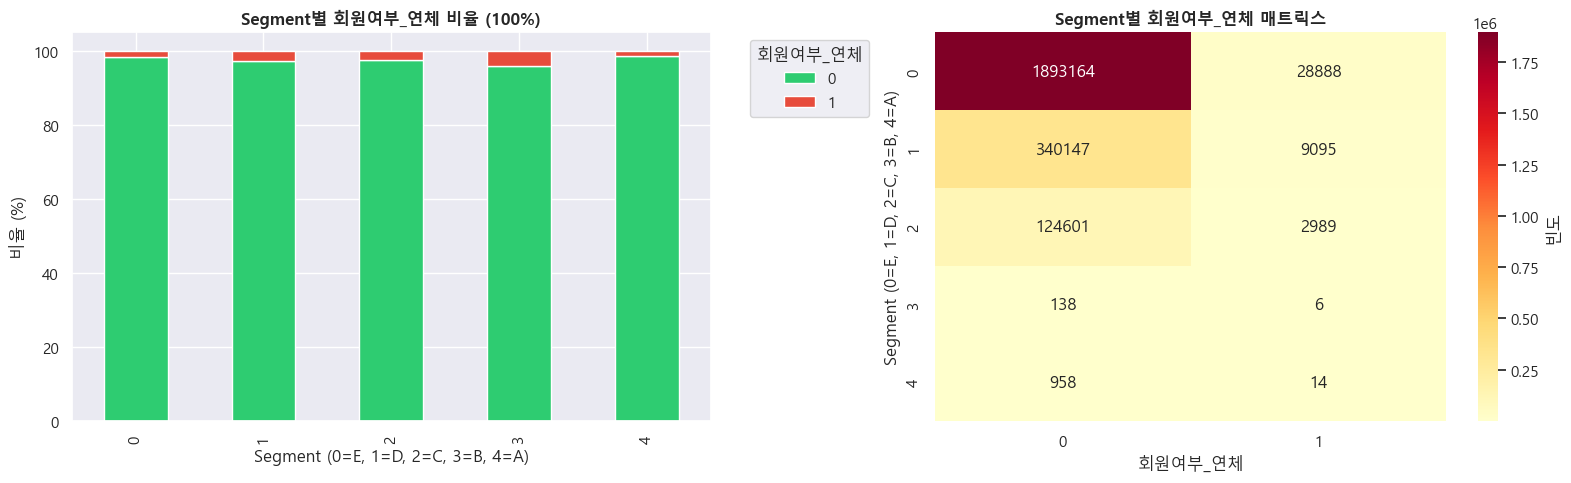

In [37]:
find_R(df, "연체")
plot_segment_comparison(df, "회원여부_연체")

In [38]:
add_list(_drop2, "회원여부_연체")

- 회원여부_연체의 경우, 연체여부로만 비율이 딱히 따지기 힘들게 나왔기 때문에, 사용이 불가능해보인다. 이후에 나오는 데이터와 함께 사용하는것이 좋아보인다.

In [39]:
find_R(df, "신용")

소지여부_신용  소지카드수_유효_신용  소지카드수_이용가능_신용  입회경과개월수_신용  유효카드수_신용체크  유효카드수_신용  \
0             1            1              1          67           2         1   
1             1            1              1          12           1         1   
2             1            1              1         124           2         1   
3             1            2              2          27           3         2   
4             1            1              1           2           2         1   
...         ...          ...            ...         ...         ...       ...   
399995        1            1              1         209           2         1   
399996        1            1              1          17           1         1   
399997        1            1              1         115           1         1   
399998        1            1              1          71           1         1   
399999        1            1              1           7           2         2   

        유효카드수_신용_가족  이용가능카드수_신용체크  이용가능카드수_신용  이용가능카드수_신용_가족  ...  \
0                 0             2           1              0  ...   
1                 0             1           1              0  ...   
2                 0             2           1              0  ...   
3                 0             3           2              0  ...   
4                 0             2           1              0  ...   
...             ...           ...         ...            ...  ...   
399995            0             2           1              0  ...   
399996            0             1           1              0  ...   
399997            0             1           1              0  ...   
399998            0             1           1              0  ...   
399999            0             2           2              0  ...   

        이용금액_R3M_신용체크  이용금액_R3M_신용  이용금액_R3M_신용_가족  _1순위신용체크구분  _2순위신용체크구분  \
0                 196          196               0           0          체크   
1               13475        13475               0           0         NaN   
2               23988        23988               0           0          체크   
3                3904         3904               0           0          체크   
4                1190            0               0           0          체크   
...               ...          ...             ...         ...         ...   
399995          10755         7267               0           0          체크   
399996          27636        27636               0           0         NaN   
399997          23187        23187               0           0         NaN   
399998              0            0               0           0         NaN   
399999          21463        21463               0           0          신용   

        최종유효년월_신용_이용가능  최종유효년월_신용_이용 보유여부_해외겸용_신용_본인  이용가능여부_해외겸용_신용_본인  \
0             202110.0      202112.0               0                  0   
1             202112.0      202204.0               0                  0   
2             202111.0      202201.0               0                  0   
3             202201.0      202111.0               1                  1   
4             202201.0           NaN               0                  0   
...                ...           ...             ...                ...   
399995        202110.0           NaN               1                  1   
399996        202110.0      202108.0               1                  1   
399997        202110.0      202111.0               1                  1   
399998        202202.0           NaN               0                  0   
399999        202302.0      202211.0               0                  0   

        이용여부_3M_해외겸용_신용_본인  
0                        0  
1                        0  
2                        0  
3                        1  
4                        0  
...                    ...  
399995                   0  
399996                   1  
399997                   1  
399998                   0  
399999                   0  

[2400000 rows x 23 

In [40]:
find_R(df,"체크")

유효카드수_신용체크  유효카드수_체크  유효카드수_체크_가족  이용가능카드수_신용체크  이용가능카드수_체크  \
0                2         1            0             2           1   
1                1         0            0             1           0   
2                2         1            0             2           1   
3                3         1            0             3           1   
4                2         1            0             2           1   
...            ...       ...          ...           ...         ...   
399995           2         1            0             2           1   
399996           1         0            0             1           0   
399997           1         0            0             1           0   
399998           1         0            0             1           0   
399999           2         0            0             2           0   

        이용가능카드수_체크_가족  이용카드수_신용체크  이용카드수_체크  이용금액_R3M_신용체크  이용금액_R3M_체크  \
0                   0           1         0            196            0   
1                   0           1         0          13475            0   
2                   0           1         0          23988            0   
3                   0           1         0           3904            0   
4                   0           1         1           1190         1190   
...               ...         ...       ...            ...          ...   
399995              0           1         1          10755         3488   
399996              0           1         0          27636            0   
399997              0           1         0          23187            0   
399998              0           0         0              0            0   
399999              0           2         0          21463            0   

        _1순위신용체크구분 _2순위신용체크구분  
0                0         체크  
1                0        NaN  
2                0         체크  
3                0         체크  
4                0         체크  
...            ...        ...  
399995           0         체크  
399996           0        NaN  
399997           0        NaN  
399998           0        NaN  
399999           0         신용  

[2400000 rows x 12 columns]

In [41]:
find_R(df, "이용금액")

이용금액_R3M_신용체크  이용금액_R3M_신용  이용금액_R3M_신용_가족  이용금액_R3M_체크  _1순위카드이용금액  \
0                 196          196               0            0        3681   
1               13475        13475               0            0       13323   
2               23988        23988               0            0       24493   
3                3904         3904               0            0        5933   
4                1190            0               0         1190           0   
...               ...          ...             ...          ...         ...   
399995          10755         7267               0         3488        5640   
399996          27636        27636               0            0       26357   
399997          23187        23187               0            0       17171   
399998              0            0               0            0           0   
399999          21463        21463               0            0        6984   

        _2순위카드이용금액  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
399995           0  
399996           0  
399997           0  
399998           0  
399999       14564  

[2400000 rows x 6 columns]

In [42]:
find_R(df, "가족")

유효카드수_신용_가족  유효카드수_체크_가족  이용가능카드수_신용_가족  이용가능카드수_체크_가족  이용카드수_신용_가족  \
0                 0            0              0              0            0   
1                 0            0              0              0            0   
2                 0            0              0              0            0   
3                 0            0              0              0            0   
4                 0            0              0              0            0   
...             ...          ...            ...            ...          ...   
399995            0            0              0              0            0   
399996            0            0              0              0            0   
399997            0            0              0              0            0   
399998            0            0              0              0            0   
399999            0            0              0              0            0   

        이용금액_R3M_신용_가족  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
399995               0  
399996               0  
399997               0  
399998               0  
399999               0  

[2400000 rows x 6 columns]

In [43]:

# 1. 파생 변수 생성 함수
def create_features(df):
    # 카드 활용도 (이용 / 유효)
    df['카드활용도_가족'] = df['이용카드수_신용_가족'] / df['유효카드수_신용_가족'].replace(0, 1)
    
    # 잠재 휴면 비중 (유효 - 이용가능 / 유효)
    df['잠재휴면비중'] = (df['유효카드수_신용_가족'] - df['이용가능카드수_신용_가족']) / df['유효카드수_신용_가족'].replace(0, 1)
    
    # 사용가능 여력 (이용가능 - 이용)
    df['사용가능여력'] = df['이용가능카드수_신용_가족'] - df['이용카드수_신용_가족']
    
    return df

create_features(df)

남녀구분코드  연령  Segment  회원여부_이용가능  회원여부_이용가능_CA  회원여부_이용가능_카드론  소지여부_신용  \
0            2  40        1          1             1              0        1   
1            1  30        0          1             1              1        1   
2            1  30        2          1             1              0        1   
3            2  40        1          1             1              0        1   
4            2  40        0          1             1              1        1   
...        ...  ..      ...        ...           ...            ...      ...   
399995       2  70        0          1             1              1        1   
399996       2  50        1          1             1              1        1   
399997       1  30        2          1             1              0        1   
399998       1  40        0          1             1              1        1   
399999       2  40        0          1             1              0        1   

        소지카드수_유효_신용  소지카드수_이용가능_신용  입회경과개월수_신용  ...  제휴연회비_B0M  \
0                 1              1          67  ...          0   
1                 1              1          12  ...          0   
2                 1              1         124  ...          0   
3                 2              2          27  ...          0   
4                 1              1           2  ...          0   
...             ...            ...         ...  ...        ...   
399995            1              1         209  ...          0   
399996            1              1          17  ...          0   
399997            1              1         115  ...          0   
399998            1              1          71  ...          0   
399999            1              1           7  ...          0   

        청구금액_기본연회비_B0M  청구금액_제휴연회비_B0M  카드신청건수  Life_Stage  최종카드발급경과월  \
0                    0               0       0     자녀성장(2)         22   
1                    0               0       0     자녀성장(1)         18   
2                    0               0       0       자녀출산기         20   
3                    0               0       1     자녀성장(2)         17   
4                    0               0       1     자녀성장(1)         15   
...                ...             ...     ...         ...        ...   
399995               0               0       0        노년생활         39   
399996               0               0       0     자녀성장(2)         24   
399997               0               0       0       자녀출산기         18   
399998               0               0       0     자녀성장(1)         27   
399999               0               0       0     자녀성장(1)         18   

        finance_auth_score  카드활용도_가족  잠재휴면비중  사용가능여력  
0                        2       0.0     0.0       0  
1                        3       0.0     0.0       0  
2                        2       0.0     0.0       0  
3                        2       0.0     0.0       0  
4                        3       0.0     0.0       0  
...                    ...       ...     ...     ...  
399995                   3       0.0     0.0       0  
399996                   3       0.0     0.0       0  
399997                   2       0.0     0.0       0  
399998                   3       0.0     0.0       0  
399999                   2       0.0     0.0       0  

[2400000 rows x 68 columns]

<Axes: >

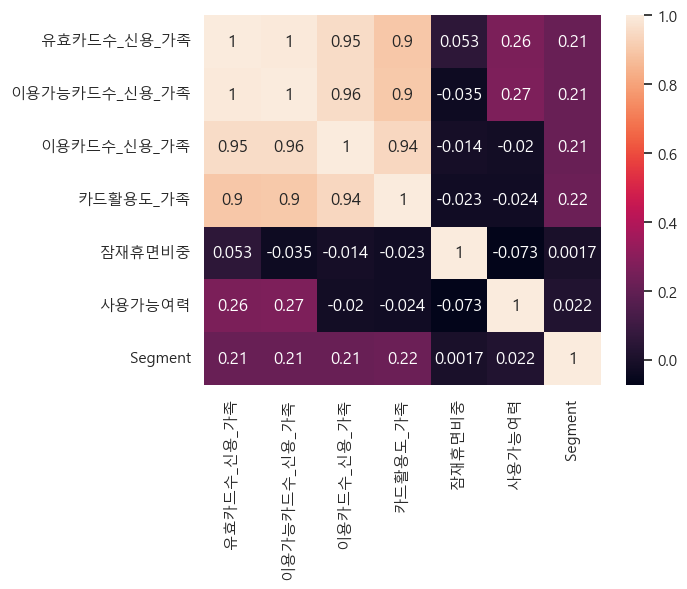

In [44]:
cols = ["유효카드수_신용_가족", "이용가능카드수_신용_가족", "이용카드수_신용_가족", "카드활용도_가족", "잠재휴면비중", "사용가능여력", "Segment"]
sns.heatmap(df[cols].corr(), annot = True)

In [45]:
# Segment에 미치는 상관관계가 작고, plot으로 확인한 결과 결과값이 매우 적기 때문에 사용하기 어려울 것으로 보인다.
df = df.drop(["잠재휴면비중", "사용가능여력"],axis= 1)

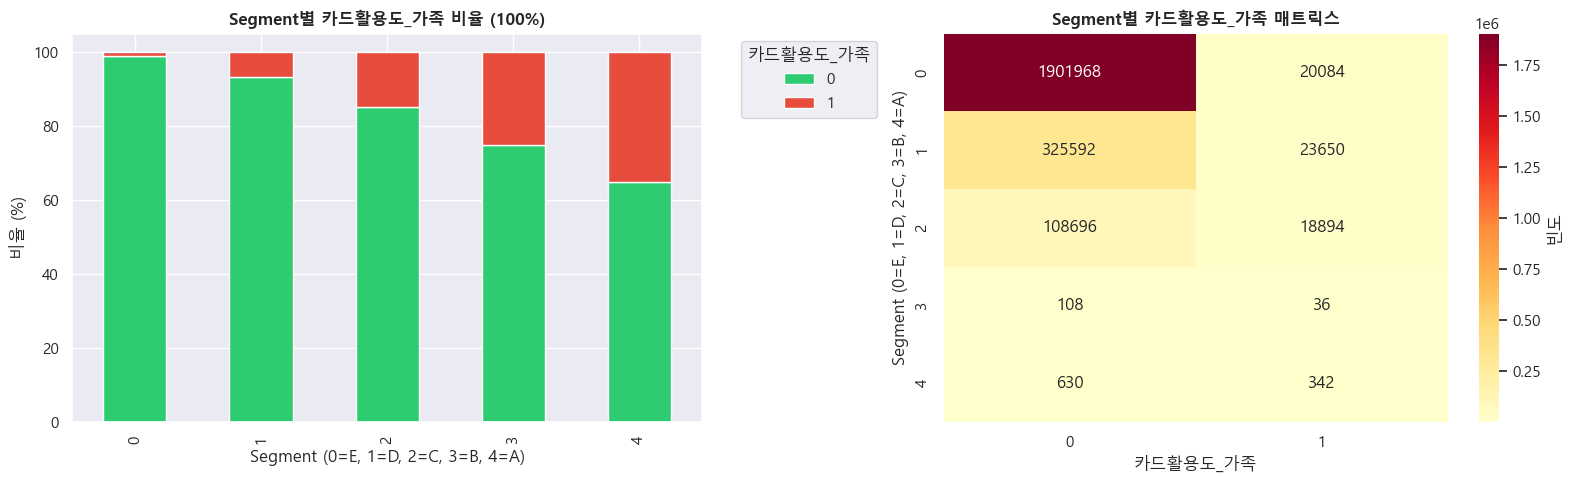

In [46]:
df["카드활용도_가족"] = np.where(df["카드활용도_가족"] > 0, 1, 0)
plot_segment_comparison(df, "카드활용도_가족")

In [ ]:
df[["Segment", "카드활용도_가족", ]].corr()

Segment  카드활용도_가족
Segment   1.000000  0.222988
카드활용도_가족  0.222988  1.000000

In [50]:
df[["유효카드수_신용_가족", "이용가능카드수_신용_가족", "이용카드수_신용_가족"]].corr()

유효카드수_신용_가족  이용가능카드수_신용_가족  이용카드수_신용_가족
유효카드수_신용_가족       1.000000       0.995695     0.954676
이용가능카드수_신용_가족     0.995695       1.000000     0.957334
이용카드수_신용_가족       0.954676       0.957334     1.000000

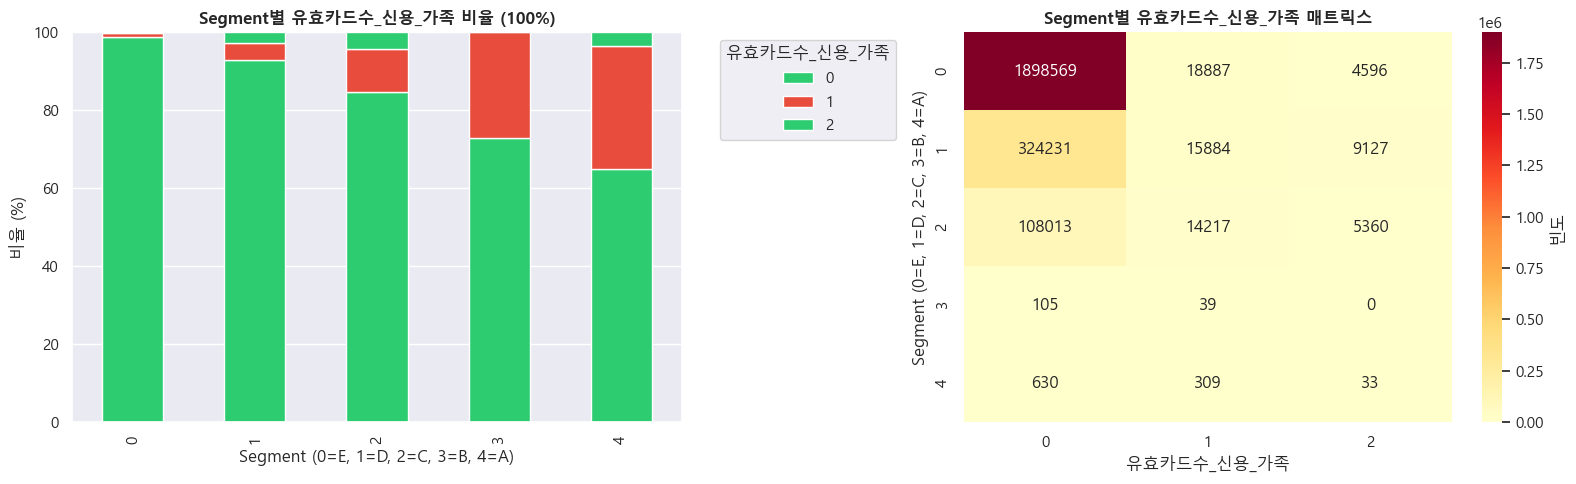

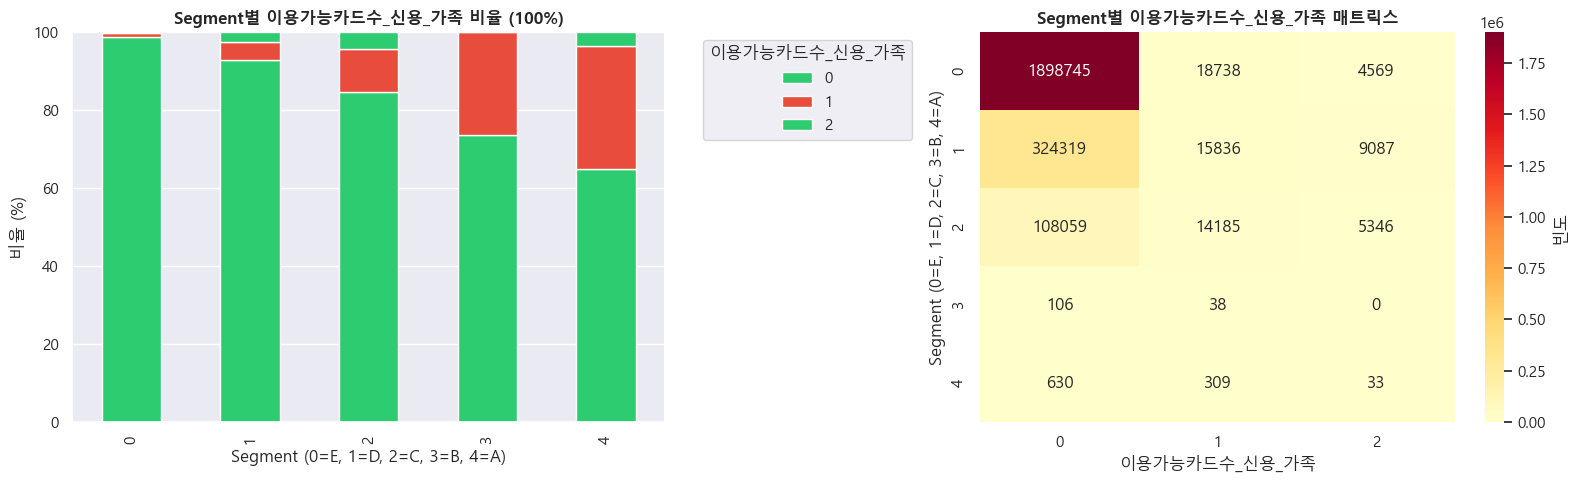

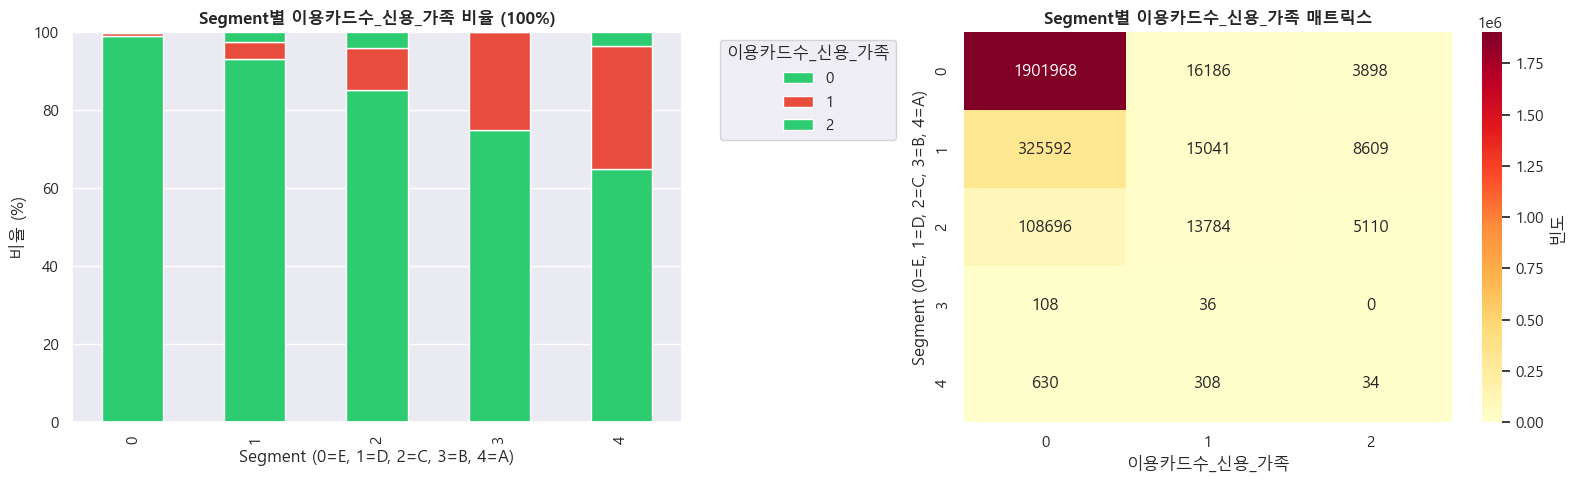

In [48]:
plot_segment_comparison(df, "유효카드수_신용_가족")
plot_segment_comparison(df, "이용가능카드수_신용_가족")
plot_segment_comparison(df, "이용카드수_신용_가족")

# 체크 카드의 경우, 거의 의미 없을정도로 데이터 부족 및 존재가 적다.
# plot_segment_comparison(df, "유효카드수_체크_가족")
# plot_segment_comparison(df, "이용가능카드수_체크_가족")
# plot_segment_comparison(df, "이용카드수_체크_가족")

In [48]:
add_list(_drop2, ["유효카드수_신용_가족", "이용가능카드수_신용_가족", "이용카드수_신용_가족", "유효카드수_체크_가족", "이용가능카드수_체크_가족"])

In [50]:
# 4개 칼럼의 합과 이용금액_R3M_신용체크가 같은지 확인 (허용오차 포함)
df['calculated_sum'] = (
    df['이용금액_R3M_신용'] +
    df['이용금액_R3M_체크']
)

# 허용오차 설정 (1 또는 원하는 값으로 조정)
tolerance = 1

# 1. 차이가 허용오차 이내인지 확인
is_almost_equal = (
    (df['calculated_sum'] - df['이용금액_R3M_신용체크']).abs() <= tolerance).all()
print(f"허용오차({tolerance}) 이내로 거의 같은가? {is_almost_equal}")

# 2. 허용오차를 초과하는 부분 찾기
difference = (df['calculated_sum'] - df['이용금액_R3M_신용체크']).abs()
exceeds_tolerance = difference > tolerance
print(f"\n허용오차를 초과하는 행의 개수: {exceeds_tolerance.sum()}")

# 3. 초과하는 부분의 상세 내용 보기
if exceeds_tolerance.sum() > 0:
    print("\n허용오차를 초과하는 부분 상세:")
    print(df[exceeds_tolerance][['이용금액_R3M_신용', '이용금액_R3M_신용_가족', 
                                  '이용금액_R3M_체크', '이용금액_R3M_체크_가족',
                                  'calculated_sum', '이용금액_R3M_신용체크']])
else:
    print("\n모두 허용오차 이내입니다! ✓")

# 4. 차이값 통계
print(f"\n차이의 최대값: {difference.max()}")
print(f"차이의 평균값: {difference.mean():.2f}")
print(f"차이의 중앙값: {difference.median():.2f}")

# 임시 칼럼 제거
df = df.drop('calculated_sum', axis=1)

허용오차(1) 이내로 거의 같은가? True

허용오차를 초과하는 행의 개수: 0

모두 허용오차 이내입니다! ✓

차이의 최대값: 1
차이의 평균값: 0.07
차이의 중앙값: 0.00


In [51]:
add_list(_drop2, ["이용금액_R3M_신용", "이용금액_R3M_체크",'이용금액_R3M_신용_가족'])

- 1원의 차이가 있긴하지만, 이용금액_R3M_신용, 이용금액_R3M_체크의 합이 이용금액_R3M_신용체크과 거의 동일하므로 해당 항목을 삭제하고 이용금액_R3M_신용체크를 사용한다.

In [52]:
df[["이용금액_R3M_신용체크",'이용금액_R3M_신용_가족',"Segment"]].corr()

이용금액_R3M_신용체크  이용금액_R3M_신용_가족   Segment
이용금액_R3M_신용체크        1.000000        0.361453  0.622827
이용금액_R3M_신용_가족       0.361453        1.000000  0.235564
Segment              0.622827        0.235564  1.000000

In [53]:
df.columns

Index(['남녀구분코드', '연령', 'Segment', '회원여부_이용가능', '회원여부_이용가능_CA', '회원여부_이용가능_카드론',
       '소지여부_신용', '소지카드수_유효_신용', '소지카드수_이용가능_신용', '입회경과개월수_신용', '회원여부_연체',
       '이용거절여부_카드론', '동의여부_한도증액안내', '수신거부여부_TM', '수신거부여부_DM', '수신거부여부_메일',
       '수신거부여부_SMS', '가입통신회사코드', '탈회횟수_누적', '최종탈회후경과월', '탈회횟수_발급6개월이내',
       '탈회횟수_발급1년이내', '거주시도명', '마케팅동의여부', '유효카드수_신용체크', '유효카드수_신용',
       '유효카드수_신용_가족', '유효카드수_체크', '유효카드수_체크_가족', '이용가능카드수_신용체크', '이용가능카드수_신용',
       '이용가능카드수_신용_가족', '이용가능카드수_체크', '이용가능카드수_체크_가족', '이용카드수_신용체크',
       '이용카드수_신용', '이용카드수_신용_가족', '이용카드수_체크', '이용금액_R3M_신용체크', '이용금액_R3M_신용',
       '이용금액_R3M_신용_가족', '이용금액_R3M_체크', '_1순위카드이용금액', '_1순위카드이용건수',
       '_1순위신용체크구분', '_2순위카드이용금액', '_2순위카드이용건수', '_2순위신용체크구분',
       '최종유효년월_신용_이용가능', '최종유효년월_신용_이용', '보유여부_해외겸용_본인', '이용가능여부_해외겸용_본인',
       '이용여부_3M_해외겸용_본인', '보유여부_해외겸용_신용_본인', '이용가능여부_해외겸용_신용_본인',
       '이용여부_3M_해외겸용_신용_본인', '연회비발생카드수_B0M', '기본연회비_B0M', '제휴연회비_B0M',
       '청구금액_기본연회비_B0M', '청구금액_제휴연회비_B0M', '카드신청건수', 'Life_St

Index(['탈회횟수_누적', '최종탈회후경과월', '탈회횟수_발급6개월이내', '탈회횟수_발급1년이내'], dtype='str')


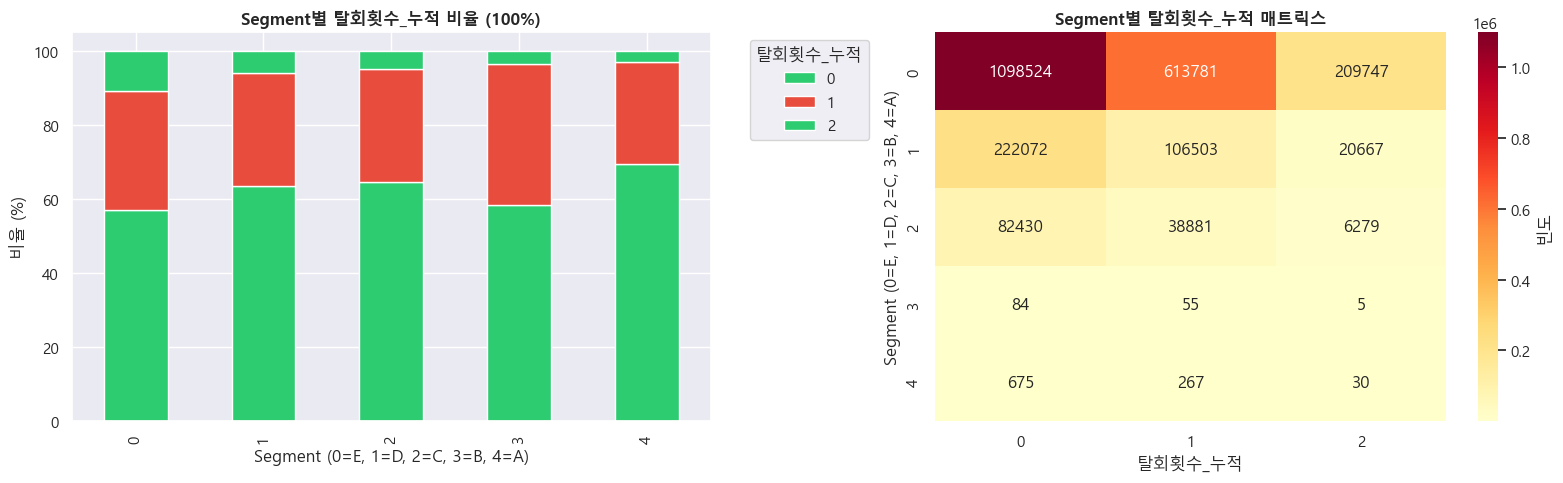

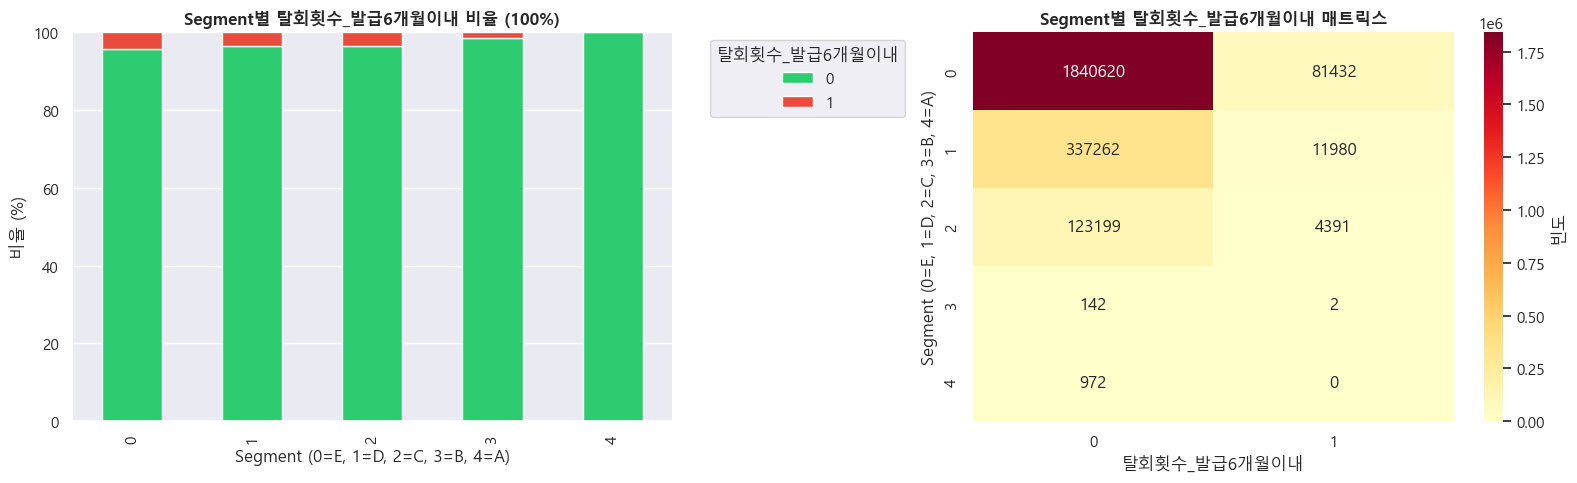

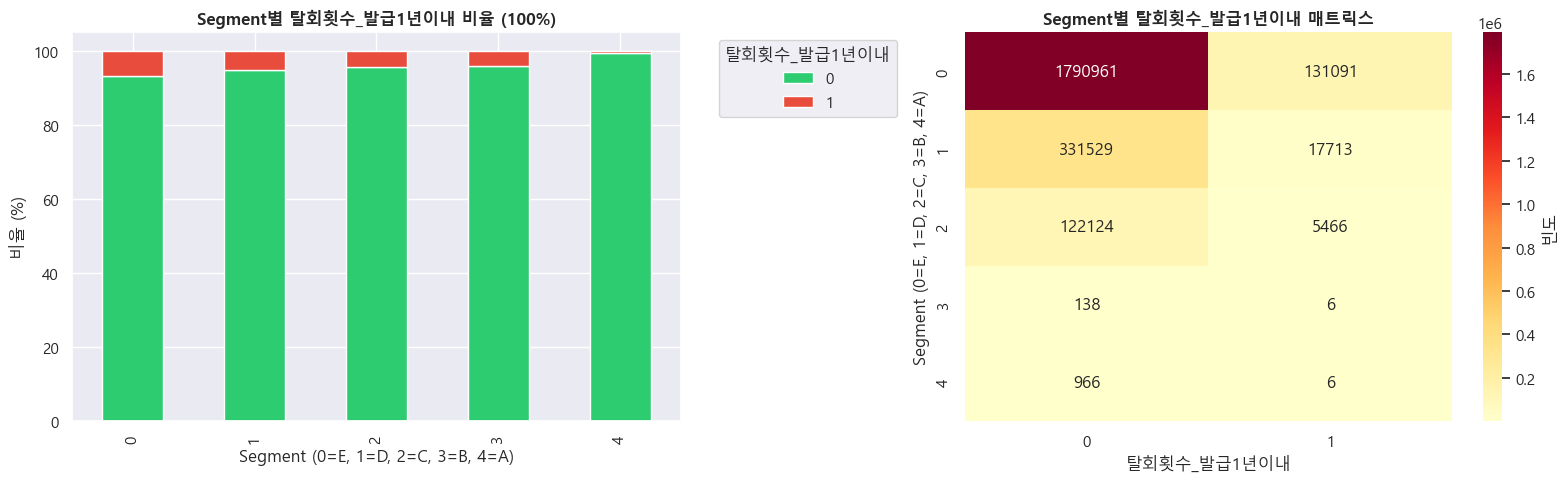

탈회횟수_발급6개월이내
0    2302195
1      97805
Name: count, dtype: int64


In [54]:
print(find_R(df, "탈회").columns)
plot_segment_comparison(df, "탈회횟수_누적")
plot_segment_comparison(df, "탈회횟수_발급6개월이내")
plot_segment_comparison(df, "탈회횟수_발급1년이내")
print(df["탈회횟수_발급6개월이내"].value_counts())
add_list(_drop2,['탈회횟수_누적', '최종탈회후경과월', '탈회횟수_발급6개월이내', '탈회횟수_발급1년이내'])

In [55]:
def create_churn_features(df):
    # 1. Zero Division 방지를 위한 아주 작은 값 (epsilon) 또는 1 더하기 전략 사용
    # 여기서는 직관적인 해석을 위해 분모에 1을 더하는 방식을 주로 사용합니다.

    # [누적 탈회 밀도]
    # 가입 기간(Total_Months) 정보가 있다면 사용 (없다면 전체 데이터의 최대 기간 대비로 대체 가능)
    # 여기서는 '고객의 금융 활동 기간 중 탈회가 얼마나 잦았나'를 측정합니다.
    df['누적탈회밀도'] = df['탈회횟수_누적'] / (df['최종탈회후경과월'] + 1)

    # 2. 결측치 및 무한대 처리 (CatBoost는 NaN을 알아서 처리하지만 깔끔하게 정리)
    cols = ['누적탈회밀도']
    df[cols] = df[cols].replace([np.inf, -np.inf], 0).fillna(0)
    
    return df

def create_advanced_features(df):
    # 1. 탈회 원격도: 전체 탈회 중 과거(1년 전) 비중 (A, B 타겟용)
    df['탈회원격도'] = (df['탈회횟수_누적'] - df['탈회횟수_발급1년이내']) / (df['탈회횟수_누적'] + 1)
    
    # 2. 활동 안정성: 마지막 탈회 후 얼마나 오래 버티고 있는가
    df['활동안정성'] = df['최종탈회후경과월'] / (df['입회경과개월수_신용'] + 1)
    # CatBoost는 Null 처리가 유연하지만, 계산으로 인한 inf는 0으로 처리
    df.replace([np.inf, -np.inf], 0, inplace=True)
    return df

# 적용
df = create_churn_features(df)
df = create_advanced_features(df)
df[["Segment", "누적탈회밀도"]].corr()
df[["Segment", '활동안정성','탈회원격도']].corr()

Segment     활동안정성     탈회원격도
Segment  1.000000 -0.113096 -0.052441
활동안정성   -0.113096  1.000000  0.447235
탈회원격도   -0.052441  0.447235  1.000000

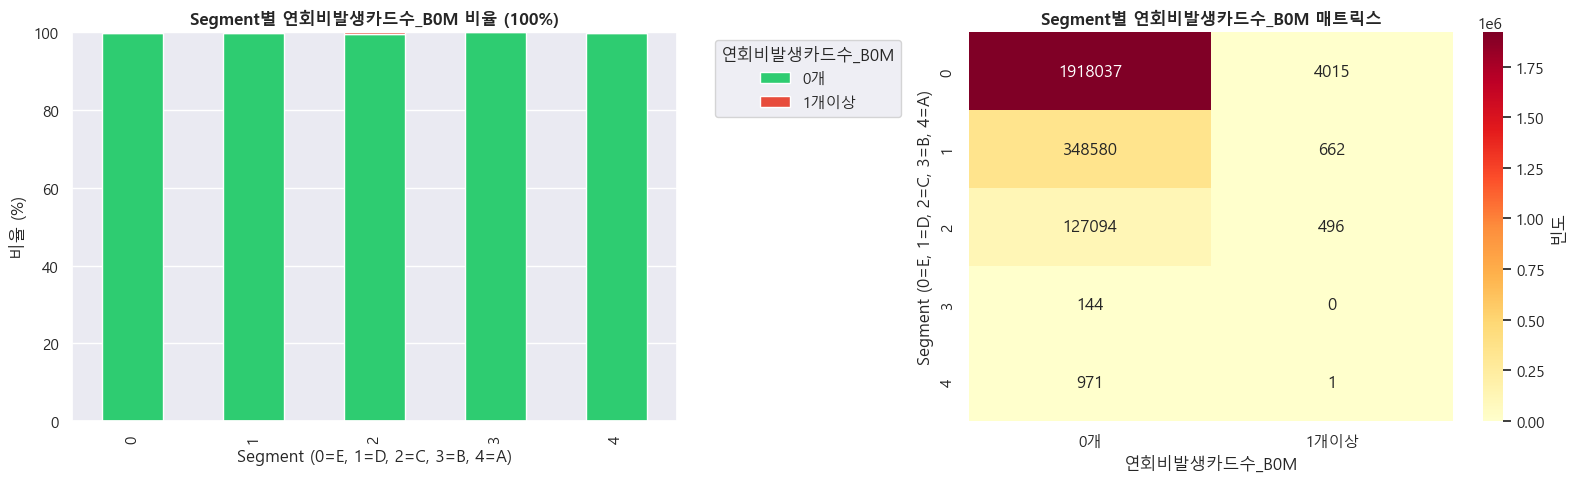

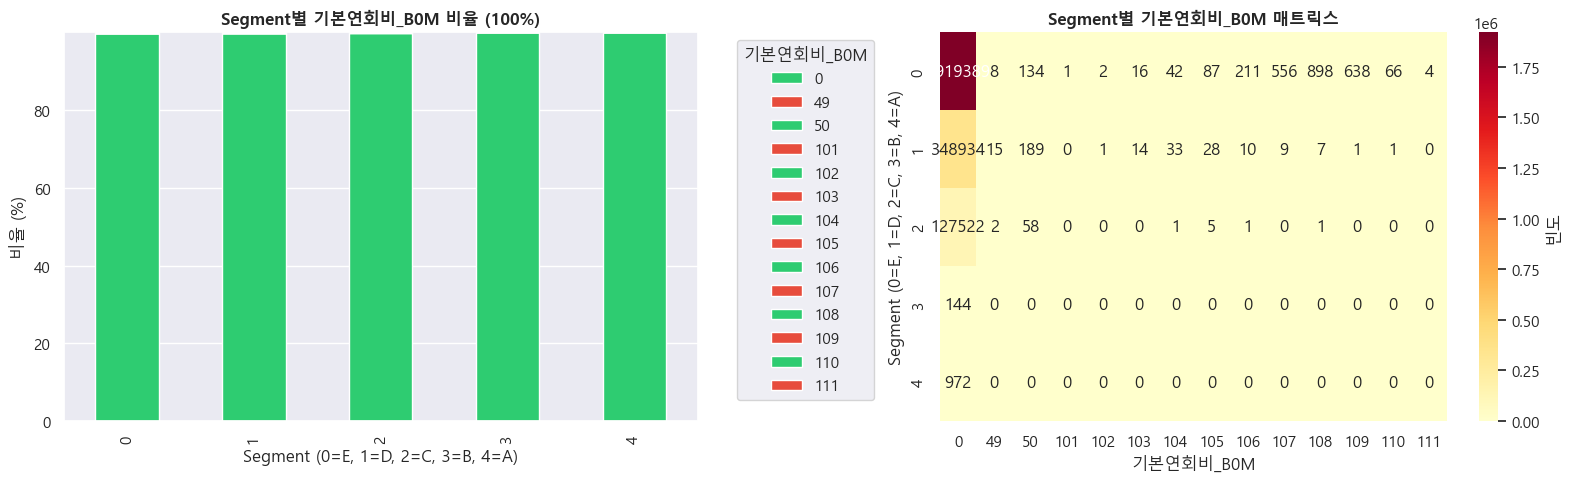

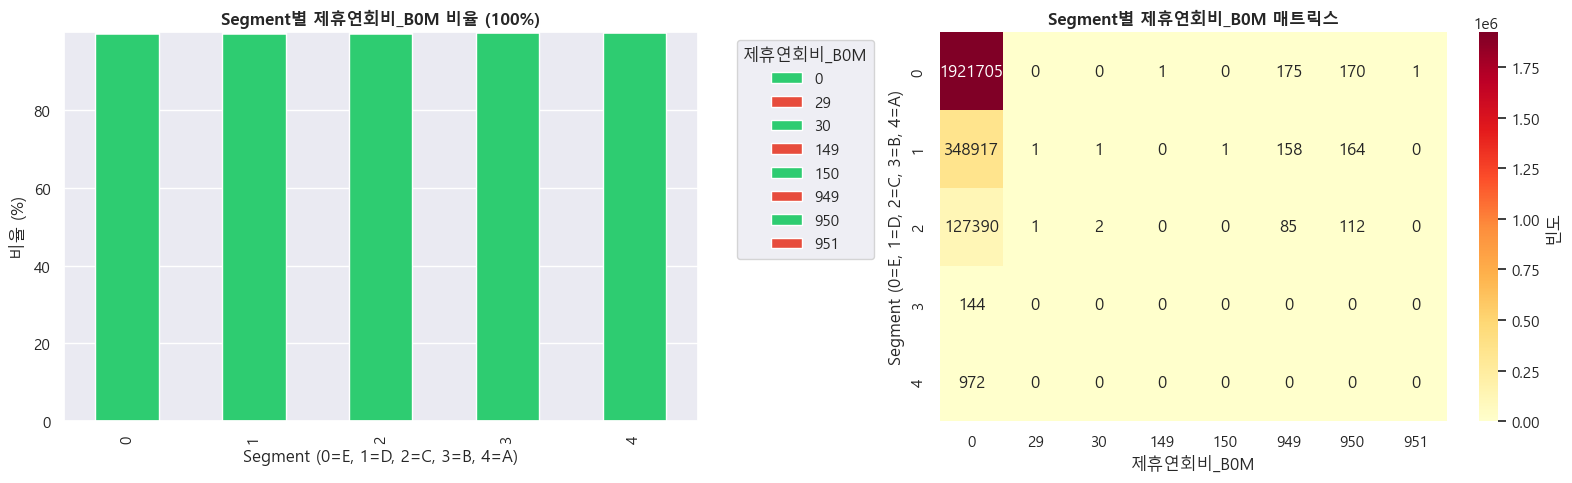

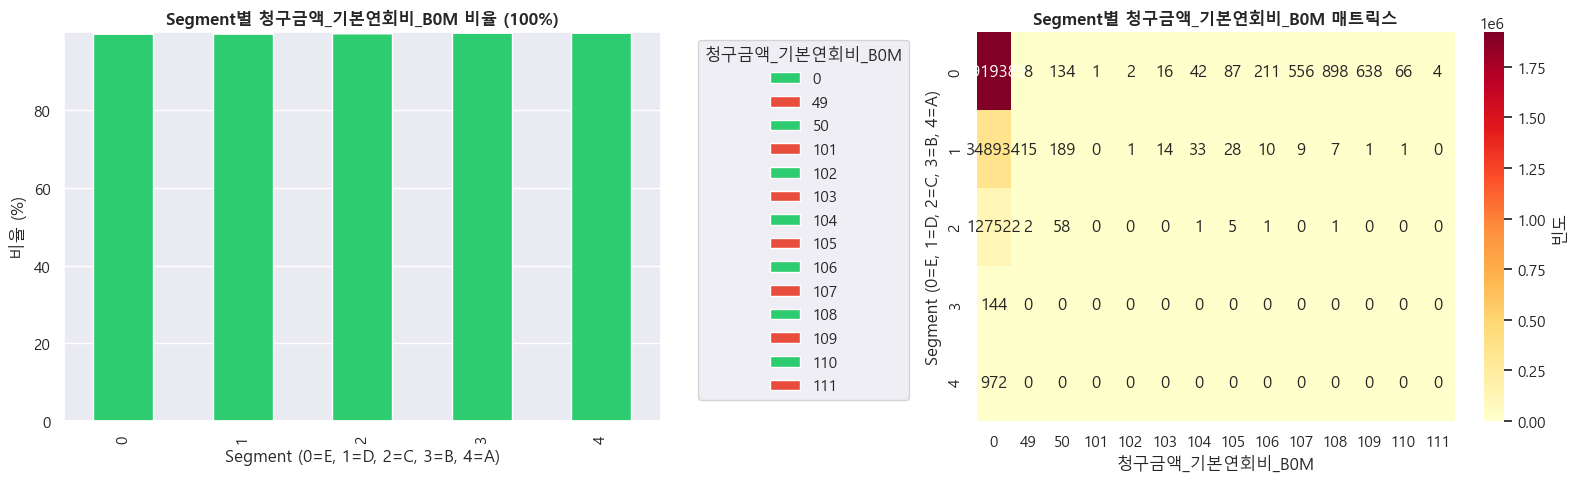

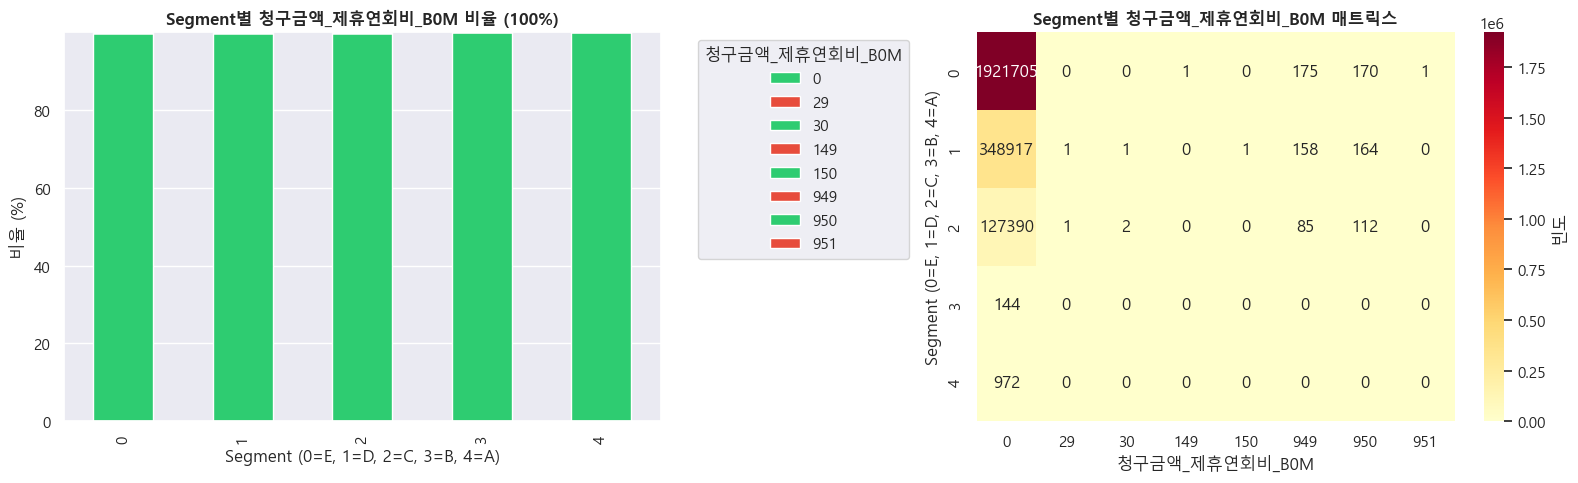

In [56]:
plot_segment_comparison(df, "연회비발생카드수_B0M")
plot_segment_comparison(df, '기본연회비_B0M')
plot_segment_comparison(df, "제휴연회비_B0M")
plot_segment_comparison(df, "청구금액_기본연회비_B0M")
plot_segment_comparison(df, "청구금액_제휴연회비_B0M")

In [57]:
temp_mapping = {"0개" : 0, "1개이상" : 1}
df["연회비발생카드수_B0M"] = df["연회비발생카드수_B0M"].map(temp_mapping)
add_list(_drop2, ['기본연회비_B0M', '제휴연회비_B0M', '청구금액_기본연회비_B0M', '청구금액_제휴연회비_B0M',"연회비발생카드수_B0M"])

- 사실상 AB의 연회비 비율이 거의 없는데, 그냥 연회비 카드 발생수만 남겨서 catboost에 남겨볼까?

- 실제로 넣어본 결과, "연회비발생카드수_B0M"도 그다지 유의미한 결과가 나오진 않았으니 제거한다.

In [58]:
df[['소지카드수_유효_신용', '소지카드수_이용가능_신용']].info()

<class 'pandas.DataFrame'>
Index: 2400000 entries, 0 to 399999
Data columns (total 2 columns):
 #   Column         Dtype
---  ------         -----
 0   소지카드수_유효_신용    int8 
 1   소지카드수_이용가능_신용  int8 
dtypes: int8(2)
memory usage: 22.9 MB


Segment  카드_즉시가용_비율  비활성_카드_수
Segment     1.000000    0.216281 -0.031697
카드_즉시가용_비율  0.216281    1.000000 -0.728079
비활성_카드_수   -0.031697   -0.728079  1.000000

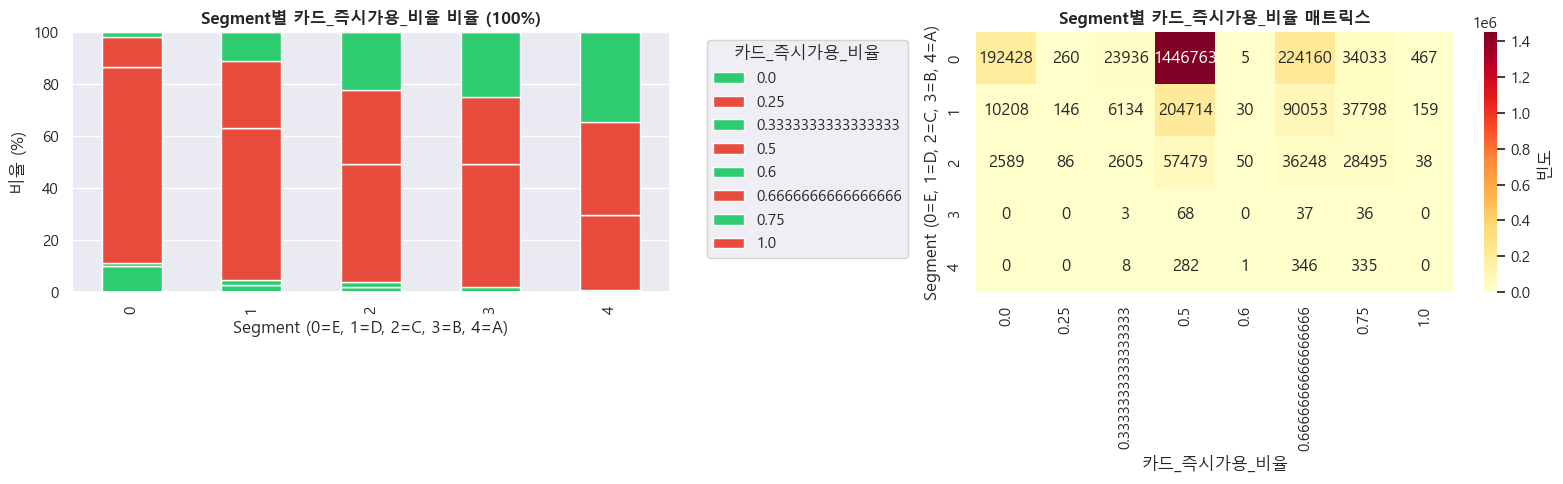

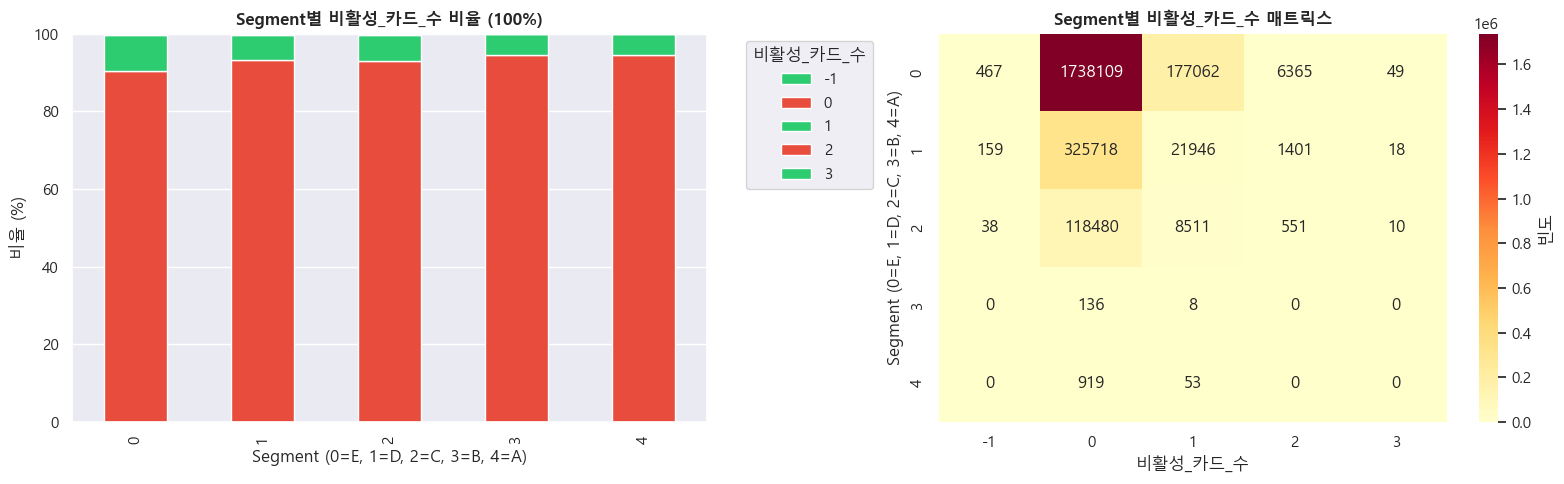

In [59]:
def create_card_count_features(df):
    # 1. 가용성 비율 (관리 능력 지표)
    df['카드_즉시가용_비율'] = df['소지카드수_이용가능_신용'] / (df['소지카드수_유효_신용'] + 1)
    
    # 2. 휴면/정지 카드 수 (방치된 카드)
    df['비활성_카드_수'] = df['소지카드수_유효_신용'] - df['소지카드수_이용가능_신용']
    
    # inf 및 결측치 처리
    cols = ['카드_즉시가용_비율', '비활성_카드_수']
    df[cols] = df[cols].replace([np.inf, -np.inf], 0).fillna(0)
    
    return df
df = create_card_count_features(df)
display(df[["Segment", '카드_즉시가용_비율', '비활성_카드_수']].corr())
plot_segment_comparison(df, "카드_즉시가용_비율")
plot_segment_comparison(df, "비활성_카드_수")

- 즉시가용 비율은 판단을 하기에 좋아보이긴 한데, 분류의 개념으로서 사용하기에 은근 괜찮아보이니 한번 사용해보는것이 좋을것 같다.
    - catboost로 실행해본결과, 그다지 좋은 참고율을 보이지 않았으므로 폐기한다.
- 비활성 카드 수는... 정확히 판단할 순 없으나 그다지 지표가 좋아보이진 않아서 없앨까 싶긴한데 한번만 돌려보자
- 카드 즉시가용 비율은 어느정도 참고를 하고 있긴하지만, 비활성카드 수는 거의 참고하지 않음

In [60]:
df[["Segment", "카드_즉시가용_비율", '소지카드수_이용가능_신용', '소지카드수_유효_신용']].corr()

Segment  카드_즉시가용_비율  소지카드수_이용가능_신용  소지카드수_유효_신용
Segment        1.000000    0.216281       0.323096     0.336633
카드_즉시가용_비율     0.216281    1.000000       0.858828     0.549822
소지카드수_이용가능_신용  0.323096    0.858828       1.000000     0.872904
소지카드수_유효_신용    0.336633    0.549822       0.872904     1.000000

In [61]:
find_R(df.drop(_drop2, axis = 1), "소지")

소지카드수_유효_신용  소지카드수_이용가능_신용
0                 1              1
1                 1              1
2                 1              1
3                 2              2
4                 1              1
...             ...            ...
399995            1              1
399996            1              1
399997            1              1
399998            1              1
399999            1              1

[2400000 rows x 2 columns]

In [62]:
pd.concat([find_R(df.drop(_drop2, axis = 1), "소지"), df[["Segment"]]], axis=1).corr()

소지카드수_유효_신용  소지카드수_이용가능_신용   Segment
소지카드수_유효_신용       1.000000       0.872904  0.336633
소지카드수_이용가능_신용     0.872904       1.000000  0.323096
Segment           0.336633       0.323096  1.000000

In [63]:
def calculate_month_diff(target_ym):
    # 연도 차이와 월 차이를 계산하여 잔여 개월수 도출
    target_year = target_ym // 100
    target_month = target_ym % 100
    
    current_year = 2026
    current_month = 2
    
    return (target_year - current_year) * 12 + (target_month - current_month)

# 1. 잔여 유효기간 피쳐 생성
df['잔여유효개월_가용'] = df['최종유효년월_신용_이용가능'].apply(calculate_month_diff)
df['잔여유효개월_실이용'] = df['최종유효년월_신용_이용'].apply(calculate_month_diff)
add_list(_drop2, ["최종유효년월_신용_이용가능", "최종유효년월_신용_이용"])

In [64]:
find_R(df, "최종")

최종탈회후경과월  최종유효년월_신용_이용가능  최종유효년월_신용_이용  최종카드발급경과월
0             61        202110.0      202112.0         22
1             98        202112.0      202204.0         18
2             60        202111.0      202201.0         20
3            100        202201.0      202111.0         17
4            101        202201.0           NaN         15
...          ...             ...           ...        ...
399995         0        202110.0           NaN         39
399996        50        202110.0      202108.0         24
399997         0        202110.0      202111.0         18
399998         0        202202.0           NaN         27
399999         0        202302.0      202211.0         18

[2400000 rows x 4 columns]

In [65]:
df[["Segment", '잔여유효개월_가용', '잔여유효개월_실이용', "최종카드발급경과월"]].corr()

Segment  잔여유효개월_가용  잔여유효개월_실이용  최종카드발급경과월
Segment     1.000000  -0.046554   -0.066244   0.022261
잔여유효개월_가용  -0.046554   1.000000    0.984921  -0.915922
잔여유효개월_실이용 -0.066244   0.984921    1.000000  -0.914239
최종카드발급경과월   0.022261  -0.915922   -0.914239   1.000000

In [66]:
df.drop("잔여유효개월_가용", axis=1, inplace=True)

- 실이용만 사용하자. 가용, 실이용 모두 사용은가능하지만 상관관계가 너무 높아 하나만 쓰는 것이 좋을듯 하니, 조금 더 상관계수가 높은 실이용만 이용한다.
- 최종카드발급경과월도 같은이유로 삭제한다.

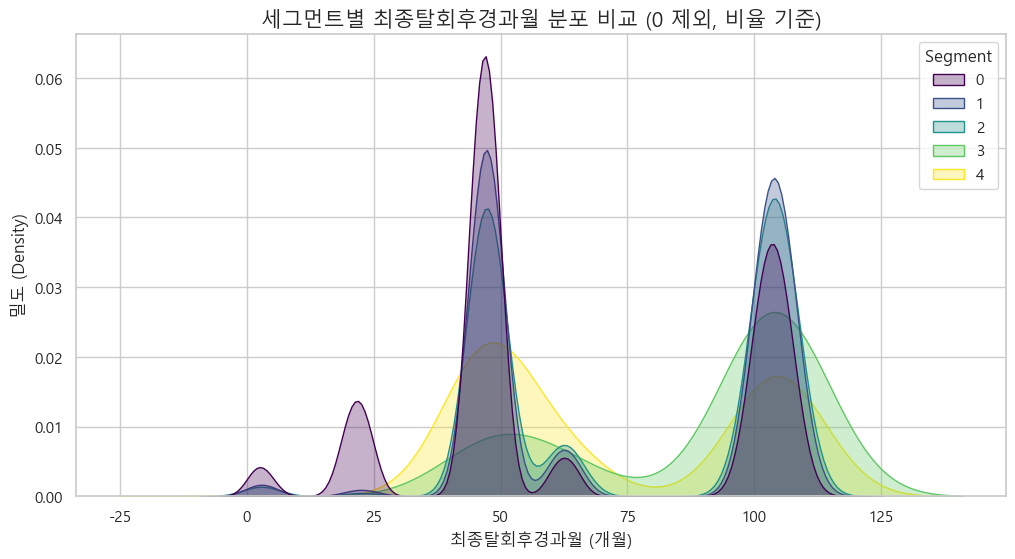

In [67]:
# 1. 한글 폰트 강제 설정 (Windows의 맑은 고딕 경로 직접 지정)
font_path = 'C:/Windows/Fonts/malgun.ttf' 
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

# 2. Seaborn 스타일 설정 (폰트 설정 이후에 해야 안전합니다)
sns.set_theme(style="whitegrid", font=font_name)

# 3. 데이터 필터링: '최종탈회후경과월'이 0보다 큰 데이터만 추출
df_plot = df[df['최종탈회후경과월'] > 0].copy()

# 4. 시각화 (KDE Plot)
plt.figure(figsize=(12, 6))

# common_norm=False: 각 세그먼트별 총 면적을 1로 정규화 -> '비율'로 비교 가능!
sns.kdeplot(data=df_plot, x='최종탈회후경과월', hue='Segment', 
            common_norm=False, fill=True, alpha=0.3, palette='viridis')

plt.title('세그먼트별 최종탈회후경과월 분포 비교 (0 제외, 비율 기준)', fontsize=15)
plt.xlabel('최종탈회후경과월 (개월)', fontsize=12)
plt.ylabel('밀도 (Density)', fontsize=12)
plt.show()

- 써먹을 수 있는지 넣어나 보자.
- 의외로 2.5이상의 importance가 나왔다. 나중에 버릴지 말지 따로 고민해보자.

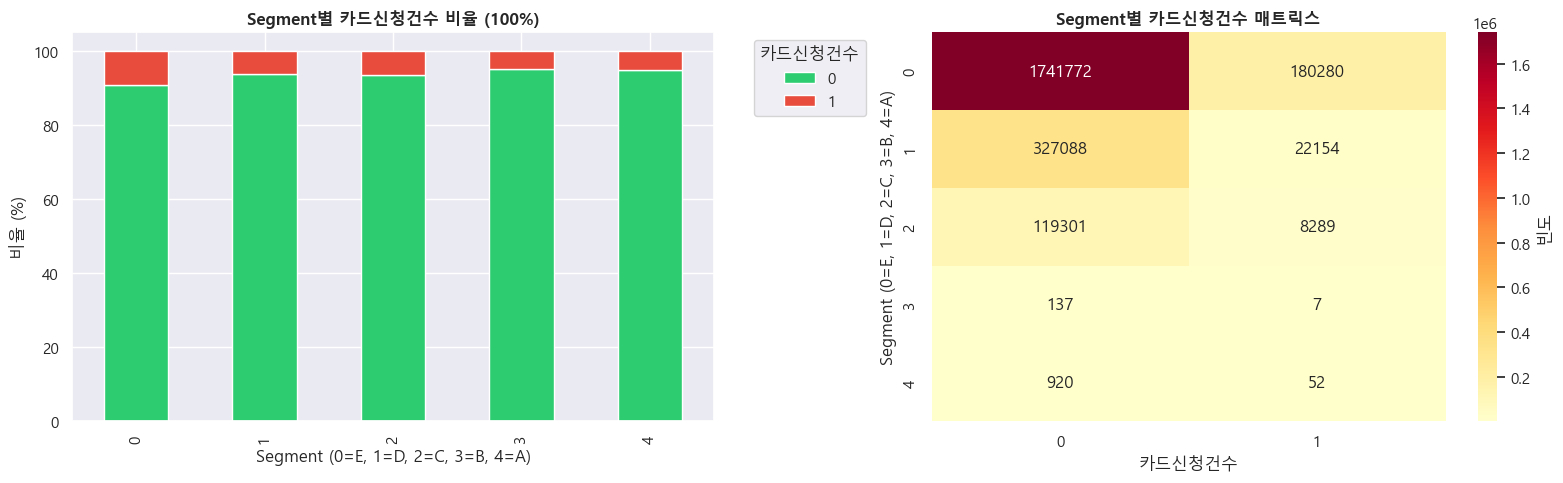

In [68]:
plot_segment_comparison(df,"카드신청건수")

In [69]:
# 시각화 및 여러 과정을 통해서 확인해봤지만 쓸모없어서 제거하는 항목
# 시간이 없으니 약식으로 빠르게 끝낸다.
add_list(_drop2, ["카드신청건수"])

In [70]:
df.drop(_drop2, axis = 1).columns

Index(['Segment', '소지카드수_유효_신용', '소지카드수_이용가능_신용', '입회경과개월수_신용', '이용거절여부_카드론',
       '동의여부_한도증액안내', '유효카드수_신용체크', '유효카드수_신용', '유효카드수_체크', '이용가능카드수_신용체크',
       '이용가능카드수_신용', '이용가능카드수_체크', '이용카드수_신용체크', '이용카드수_신용', '이용카드수_체크',
       '이용금액_R3M_신용체크', '_1순위카드이용금액', '_1순위카드이용건수', '_1순위신용체크구분', '_2순위카드이용금액',
       '_2순위카드이용건수', '_2순위신용체크구분', '보유여부_해외겸용_본인', '이용가능여부_해외겸용_본인',
       '이용여부_3M_해외겸용_본인', '보유여부_해외겸용_신용_본인', '이용가능여부_해외겸용_신용_본인',
       '이용여부_3M_해외겸용_신용_본인', 'Life_Stage', '최종카드발급경과월', 'finance_auth_score',
       '카드활용도_가족', '누적탈회밀도', '탈회원격도', '활동안정성', '카드_즉시가용_비율', '비활성_카드_수',
       '잔여유효개월_실이용'],
      dtype='str')

In [71]:
list(df.drop(_drop2, axis = 1).columns)

['Segment',
 '소지카드수_유효_신용',
 '소지카드수_이용가능_신용',
 '입회경과개월수_신용',
 '이용거절여부_카드론',
 '동의여부_한도증액안내',
 '유효카드수_신용체크',
 '유효카드수_신용',
 '유효카드수_체크',
 '이용가능카드수_신용체크',
 '이용가능카드수_신용',
 '이용가능카드수_체크',
 '이용카드수_신용체크',
 '이용카드수_신용',
 '이용카드수_체크',
 '이용금액_R3M_신용체크',
 '_1순위카드이용금액',
 '_1순위카드이용건수',
 '_1순위신용체크구분',
 '_2순위카드이용금액',
 '_2순위카드이용건수',
 '_2순위신용체크구분',
 '보유여부_해외겸용_본인',
 '이용가능여부_해외겸용_본인',
 '이용여부_3M_해외겸용_본인',
 '보유여부_해외겸용_신용_본인',
 '이용가능여부_해외겸용_신용_본인',
 '이용여부_3M_해외겸용_신용_본인',
 'Life_Stage',
 '최종카드발급경과월',
 'finance_auth_score',
 '카드활용도_가족',
 '누적탈회밀도',
 '탈회원격도',
 '활동안정성',
 '카드_즉시가용_비율',
 '비활성_카드_수',
 '잔여유효개월_실이용']

In [72]:
df[[ '_2순위카드이용금액', '_2순위카드이용건수','_1순위카드이용금액', '_1순위카드이용건수']].corr()

_2순위카드이용금액  _2순위카드이용건수  _1순위카드이용금액  _1순위카드이용건수
_2순위카드이용금액    1.000000    0.949612    0.512866    0.453552
_2순위카드이용건수    0.949612    1.000000    0.488965    0.533908
_1순위카드이용금액    0.512866    0.488965    1.000000    0.750783
_1순위카드이용건수    0.453552    0.533908    0.750783    1.000000

## 남겨둘, 혹은 생각해둬야할 목록
 - 회원여부_연체 : 여기선 그냥 삭제하는 값이지만, 연체와 관련된 데이터가 있다면 찾아서 활용할 것

In [73]:
selected_features = [
    # 1. 직접 생성한 필수 변수 (8개)
    'finance_auth_score',
    # '카드활용도_가족',
    '누적탈회밀도',
    '탈회원격도',
    '활동안정성',
    '카드_즉시가용_비율',
    # '비활성_카드_수',
    '잔여유효개월_실이용',

    # 2. 선별된 기존 핵심 변수
    '이용금액_R3M_신용체크',      # 소비 규모 대표
    '_1순위카드이용금액',         # 주력 카드 충성도
    '_1순위카드이용건수',         # 결제 빈도
    '_2순위카드이용금액',
    '이용가능카드수_신용체크',    # 실질적 금융 가용성
    '입회경과개월수_신용',        # 고객 유지 기간
    '이용여부_3M_해외겸용_본인',  # 특수/우량 소비 지표
    '동의여부_한도증액안내',       # 마케팅 수용도
    "최종탈회후경과월"
]

# 피쳐 엔지니어링(1만 해봐서, important한것만 뽑아보려고 해보는 중)

In [74]:
# df = df.drop(_drop2, axis=1)

- 피쳐엔지니어링을 통해 추가된 column ["누적탈회밀도", '활동안정성','탈회원격도', '비활성_카드_수', "카드_즉시가용_비율"]

In [75]:
column_list = []
corr_maker(df, filename = "_1st_corr.txt")
_1st_corr = read_corr(filename = "_1st_corr.txt")
_1st_corr = filter_high_corr(_1st_corr)
for corr in _1st_corr:
    add_list(column_list, corr[0])
# add_list(column_list, ["누적탈회밀도"])
# add_list(column_list, ['활동안정성','탈회원격도'])
# add_list(column_list, ['비활성_카드_수'])
# add_list(column_list,['잔여유효개월_실이용'])
# add_list(column_list, ['최종탈회후경과월'])
column_list

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16144\1076769718.py:10: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  obj_cols = temp_df.select_dtypes(include=['object']).columns


결과가 _1st_corr.txt에 저장되었습니다.
이용금액_R3M_신용체크    0.622827
이용금액_R3M_신용      0.589032
_1순위카드이용금액       0.573870
_2순위카드이용금액       0.400225
이용카드수_신용체크       0.397713
                   ...   
남녀구분코드          -0.060323
최종유효년월_신용_이용    -0.064195
잔여유효개월_실이용      -0.066244
탈회횟수_누적         -0.068744
활동안정성           -0.113096
Name: Segment, Length: 71, dtype: float64


['이용금액_R3M_신용체크',
 '이용금액_R3M_신용',
 '_1순위카드이용금액',
 '_2순위카드이용금액',
 '이용카드수_신용체크',
 '_1순위카드이용건수',
 '이용카드수_신용',
 '_2순위카드이용건수',
 '이용가능카드수_신용',
 '이용가능카드수_신용체크',
 '유효카드수_신용',
 '유효카드수_신용체크',
 '소지카드수_유효_신용',
 '소지카드수_이용가능_신용',
 '입회경과개월수_신용',
 '_2순위신용체크구분',
 '이용금액_R3M_신용_가족',
 '이용여부_3M_해외겸용_본인',
 '이용여부_3M_해외겸용_신용_본인',
 '카드활용도_가족',
 '카드_즉시가용_비율',
 '이용카드수_신용_가족',
 '유효카드수_신용_가족',
 '이용가능카드수_신용_가족',
 '이용금액_R3M_체크']

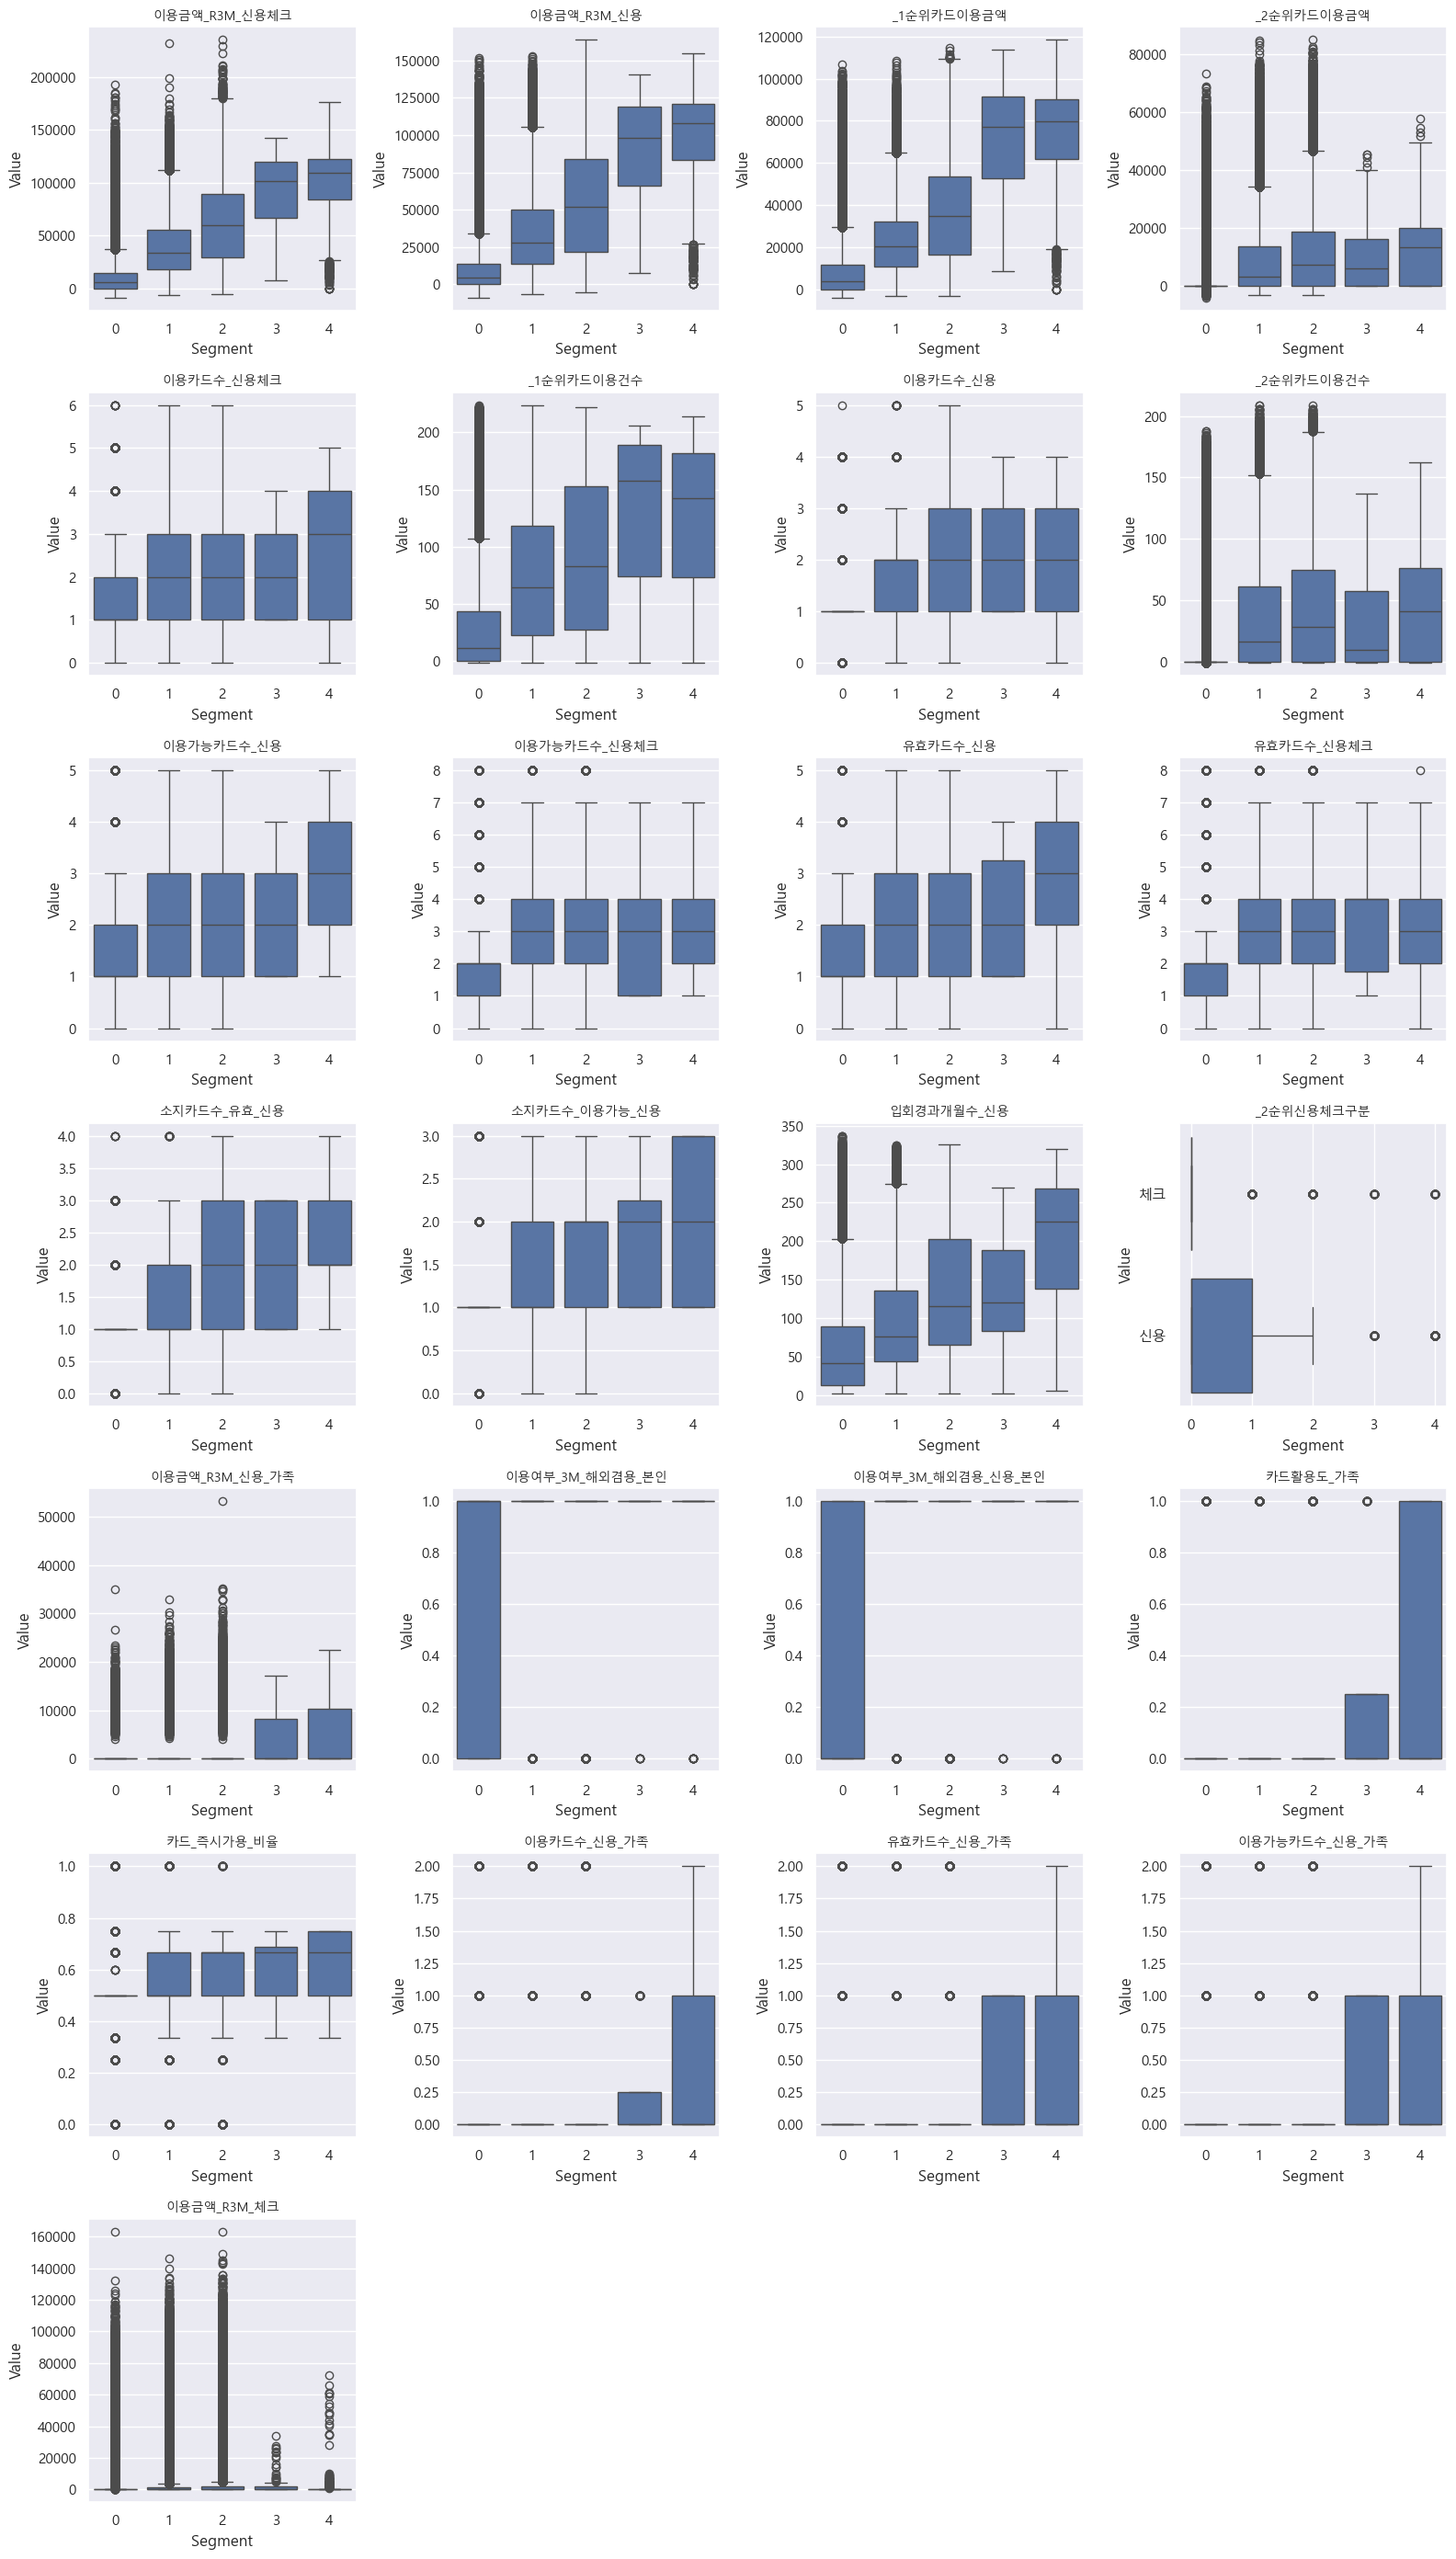

In [78]:
import matplotlib.pyplot as plt

# column_list의 개수에 따라 행 수 계산 (4열 기준)
n_cols = 4
n_rows = (len(column_list) + n_cols - 1) // n_cols

# subplots 생성
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()  # 2D 배열을 1D로 변환

# 각 column에 대해 boxplot 그리기
for idx, col in enumerate(column_list):
    # 문자열 데이터 처리 (factorize로 숫자 변환)
    temp_data = df[col].copy()
    if temp_data.dtype == 'object':
        temp_data = pd.factorize(temp_data)[0]
    else:
        temp_data = temp_data.values
    
    # Segment를 x축으로 하는 boxplot (인덱스 리셋)
    plot_df = pd.DataFrame({col: temp_data, 'Segment': df['Segment'].values})
    sns.boxplot(data=plot_df, x='Segment', y=col, ax=axes[idx])
    axes[idx].set_title(col, fontsize=10)
    axes[idx].set_ylabel('Value')

# 불필요한 subplot 숨기기
for idx in range(len(column_list), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

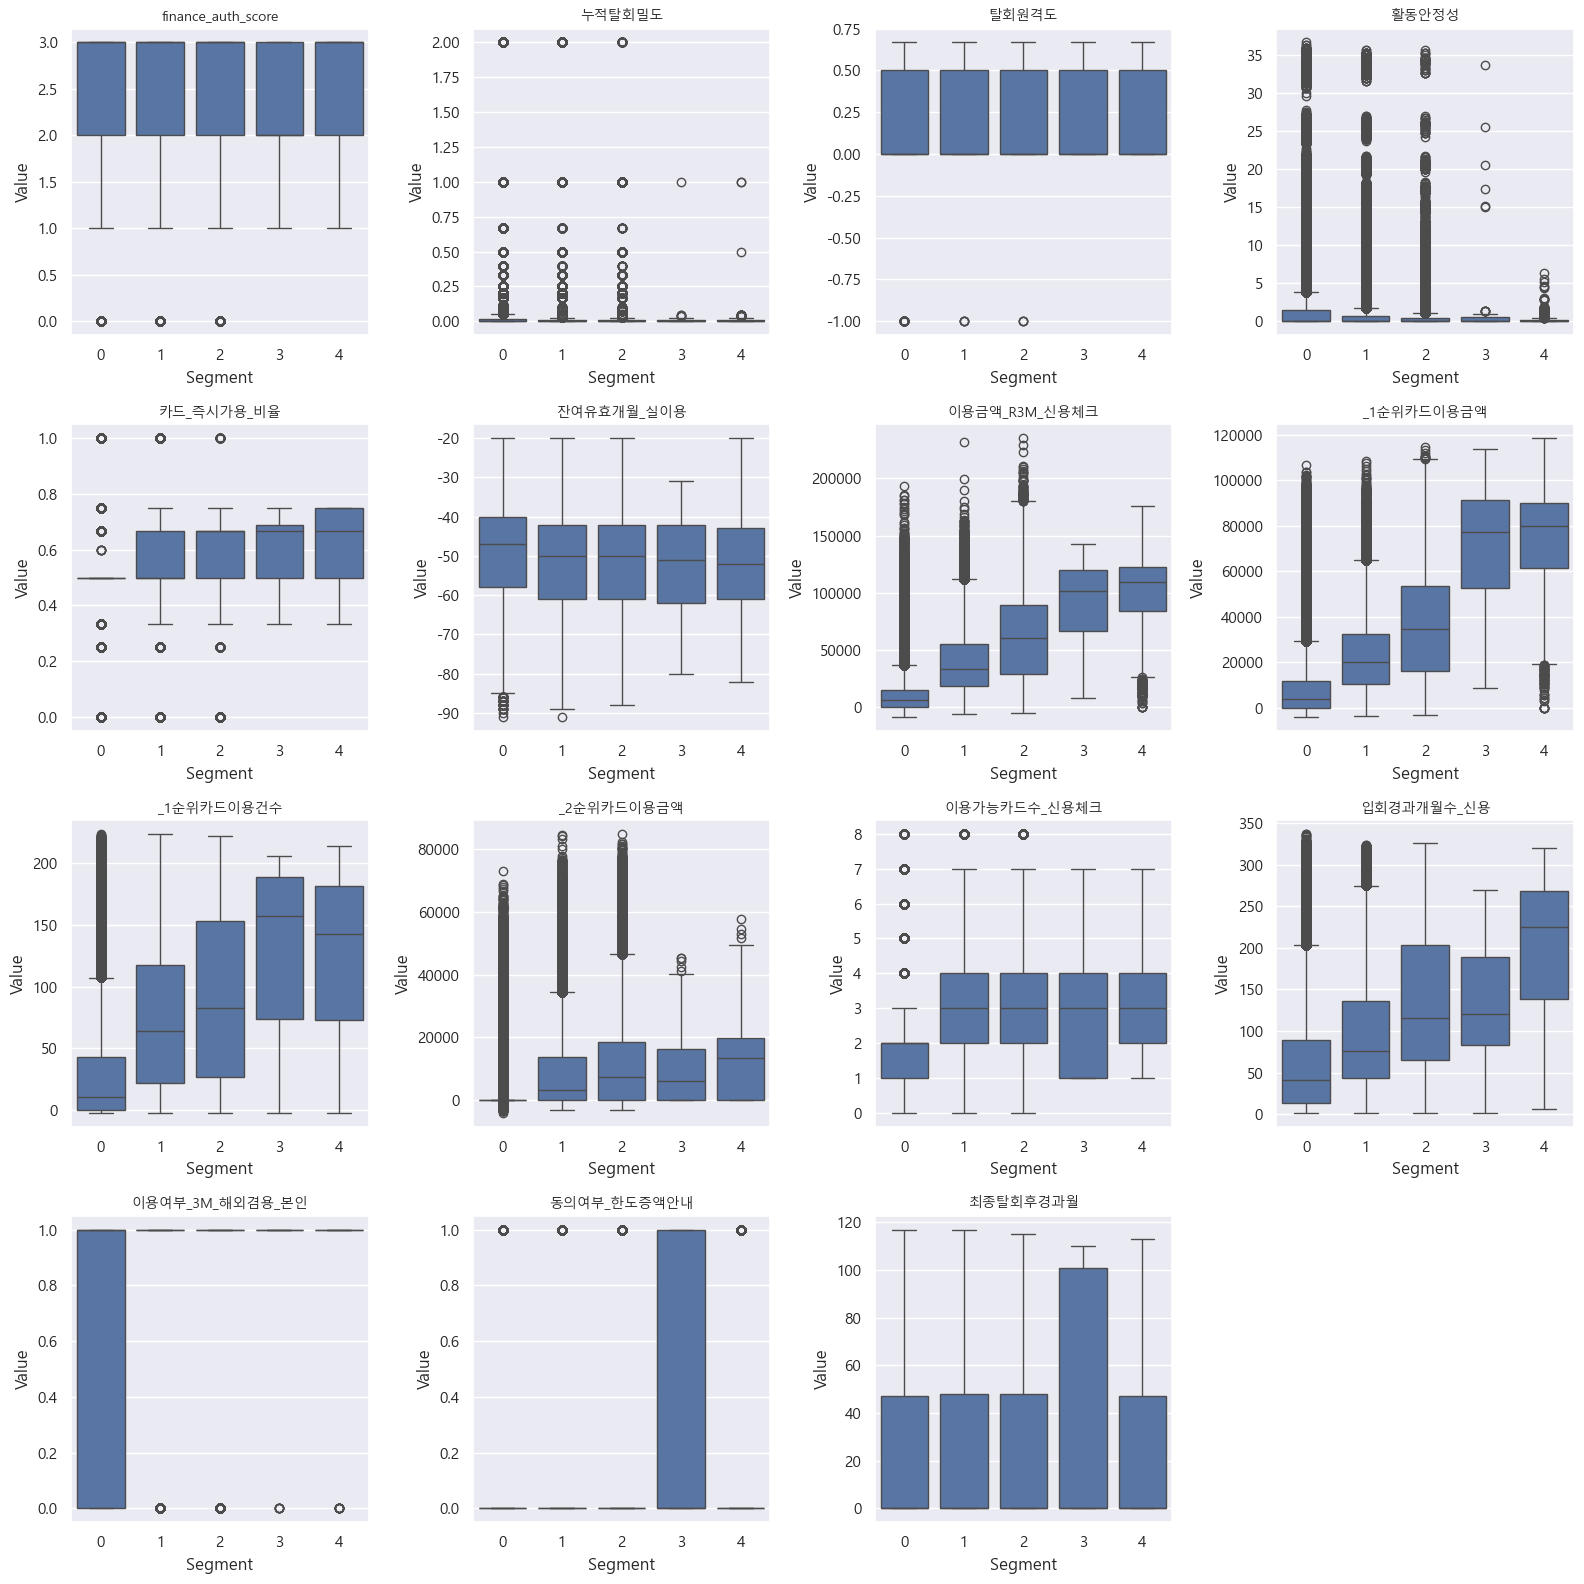

In [79]:
# column_list의 개수에 따라 행 수 계산 (4열 기준)
n_cols = 4
n_rows = (len(selected_features) + n_cols - 1) // n_cols

# subplots 생성
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()  # 2D 배열을 1D로 변환

# 각 column에 대해 boxplot 그리기
for idx, col in enumerate(selected_features):
    # 문자열 데이터 처리 (factorize로 숫자 변환)
    temp_data = df[col].copy()
    if temp_data.dtype == 'object':
        temp_data = pd.factorize(temp_data)[0]
    else:
        temp_data = temp_data.values
    
    # Segment를 x축으로 하는 boxplot (인덱스 리셋)
    plot_df = pd.DataFrame({col: temp_data, 'Segment': df['Segment'].values})
    sns.boxplot(data=plot_df, x='Segment', y=col, ax=axes[idx])
    axes[idx].set_title(col, fontsize=10)
    axes[idx].set_ylabel('Value')

# 불필요한 subplot 숨기기
for idx in range(len(selected_features), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

In [74]:
# trained_df = df[column_list].copy()
trained_df = df[selected_features]
trained_df = pd.concat([trained_df,pd.DataFrame(df["Segment"])], axis=1)

# catboost를 통해서 피쳐엔지니어 뽑아내기

In [103]:
trained_df

finance_auth_score    누적탈회밀도  탈회원격도      활동안정성  카드_즉시가용_비율  \
0                        2  0.016129    0.5   0.897059    0.500000   
1                        3  0.010101    0.5   7.538462    0.500000   
2                        2  0.016393    0.5   0.480000    0.500000   
3                        2  0.009901    0.5   3.571429    0.666667   
4                        3  0.009804    0.5  33.666667    0.500000   
...                    ...       ...    ...        ...         ...   
399995                   3  0.000000    0.0   0.000000    0.500000   
399996                   3  0.019608    0.5   2.777778    0.500000   
399997                   2  0.000000    0.0   0.000000    0.500000   
399998                   3  0.000000    0.0   0.000000    0.500000   
399999                   2  0.000000    0.0   0.000000    0.500000   

        잔여유효개월_실이용  이용금액_R3M_신용체크  _1순위카드이용금액  _1순위카드이용건수  _2순위카드이용금액  \
0            -50.0            196        3681          26           0   
1            -46.0          13475       13323          46           0   
2            -49.0          23988       24493          28           0   
3            -51.0           3904        5933           1           0   
4              NaN           1190           0          -2           0   
...            ...            ...         ...         ...         ...   
399995         NaN          10755        5640           3           0   
399996       -54.0          27636       26357          38           0   
399997       -51.0          23187       17171          33           0   
399998         NaN              0           0          -2           0   
399999       -39.0          21463        6984          -2       14564   

        이용가능카드수_신용체크  입회경과개월수_신용  이용여부_3M_해외겸용_본인  동의여부_한도증액안내  최종탈회후경과월  \
0                  2          67                0            1        61   
1                  1          12                0            0        98   
2                  2         124                0            1        60   
3                  3          27                1            1       100   
4                  2           2                1            0       101   
...              ...         ...              ...          ...       ...   
399995             2         209                1            0         0   
399996             1          17                1            0        50   
399997             1         115                1            0         0   
399998             1          71                0            0         0   
399999             2           7                0            0         0   

        Segment  
0             1  
1             0  
2             2  
3             1  
4             0  
...         ...  
399995        0  
399996        1  
399997        2  
399998        0  
399999        0  

[2400000 rows x 16 columns]

In [75]:
# train 데이터 준비
train = trained_df.copy()
X_train = train.drop('Segment', axis=1)
y_train = train['Segment']

# test 데이터 준비 (샘플로 train에서 분리)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify = y_train)

In [76]:
from sklearn.metrics import accuracy_score, f1_score

# 글로벌 변수로 best model, score 저장
best_model = None
best_f1_score = 0

# CatBoost 하이퍼파라미터 튜닝
def objective_cat(trial):
    global best_model, best_f1_score  # 두 변수 모두 global 선언
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'eval_metric': "MultiClass",
        'verbose': 0,
        'task_type': 'GPU',
        'devices': '0'
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    score = f1_score(y_test, pred, average='weighted')
    
    # Best model 저장
    if best_model is None or score > best_f1_score:
        best_model = model
        best_f1_score = score
    
    return score

study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=10)
print("Best CatBoost params:", study_cat.best_params)
print("Best CatBoost score:", study_cat.best_value)

[I 2026-02-11 13:30:36,389] A new study created in memory with name: no-name-6b6d252b-060a-41c3-9ade-c733bca98866
[I 2026-02-11 13:30:48,940] Trial 0 finished with value: 0.8490468878130508 and parameters: {'iterations': 879, 'depth': 5, 'learning_rate': 0.2569640662862287, 'l2_leaf_reg': 3.9318964766995514, 'border_count': 250}. Best is trial 0 with value: 0.8490468878130508.
[I 2026-02-11 13:30:53,788] Trial 1 finished with value: 0.8449564298062155 and parameters: {'iterations': 426, 'depth': 4, 'learning_rate': 0.09435532659545752, 'l2_leaf_reg': 7.6877469053050485, 'border_count': 109}. Best is trial 0 with value: 0.8490468878130508.
[I 2026-02-11 13:31:04,928] Trial 2 finished with value: 0.8453773900775287 and parameters: {'iterations': 811, 'depth': 5, 'learning_rate': 0.035743174821439384, 'l2_leaf_reg': 2.015314280988057, 'border_count': 240}. Best is trial 0 with value: 0.8490468878130508.
[I 2026-02-11 13:31:08,309] Trial 3 finished with value: 0.8453647886729444 and parame

Best CatBoost params: {'iterations': 985, 'depth': 6, 'learning_rate': 0.19413707500290778, 'l2_leaf_reg': 1.88576224717039, 'border_count': 165}
Best CatBoost score: 0.8511981888594854


In [77]:
# XGBoost 하이퍼파라미터 튜닝
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'device': 'cuda'
    }
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return f1_score(y_test, pred, average='weighted')

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=10)
print("Best XGBoost params:", study_xgb.best_params)
print("Best XGBoost score:", study_xgb.best_value)


[I 2026-02-11 13:32:19,014] A new study created in memory with name: no-name-1a970d4b-4a30-4ef0-b866-edea61a01a41
[I 2026-02-11 13:32:24,123] Trial 0 finished with value: 0.8458316146321634 and parameters: {'n_estimators': 219, 'max_depth': 4, 'learning_rate': 0.21731235981712654, 'subsample': 0.616893570159575, 'colsample_bytree': 0.6864268206774521, 'gamma': 1.3379330231546276, 'reg_alpha': 0.08999266462488575, 'reg_lambda': 0.6683264951943667}. Best is trial 0 with value: 0.8458316146321634.
[I 2026-02-11 13:32:28,643] Trial 1 finished with value: 0.8488034963487688 and parameters: {'n_estimators': 209, 'max_depth': 9, 'learning_rate': 0.23808300449025396, 'subsample': 0.9415609426151959, 'colsample_bytree': 0.8210907335078546, 'gamma': 4.680342795638489, 'reg_alpha': 0.9620269254372837, 'reg_lambda': 0.6473385619125156}. Best is trial 1 with value: 0.8488034963487688.
[I 2026-02-11 13:32:32,203] Trial 2 finished with value: 0.848644846562504 and parameters: {'n_estimators': 102, 'm

Best XGBoost params: {'n_estimators': 199, 'max_depth': 8, 'learning_rate': 0.20046914494545284, 'subsample': 0.5090480719617873, 'colsample_bytree': 0.8247863705752975, 'gamma': 0.3341765202901953, 'reg_alpha': 0.590534488072468, 'reg_lambda': 0.1824454308585095}
Best XGBoost score: 0.8540017087650579


In [78]:
# LightGBM 하이퍼파라미터 튜닝
def objective_lgb(trial):
    params = {
        'device': 'gpu',  # GPU 사용 설정
        'gpu_platform_id': 0, # 보통 0번 (NVIDIA 사용 시)
        'gpu_device_id': 0,   # 사용할 GPU 번호
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return f1_score(y_test, pred, average='weighted')

study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=10)
print("Best LightGBM params:", study_lgb.best_params)
print("Best LightGBM score:", study_lgb.best_value)

[I 2026-02-11 13:33:53,027] A new study created in memory with name: no-name-bc9940af-b3e7-485b-a8a5-9e60ad11c57f


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1762
[LightGBM] [Info] Number of data points in the train set: 1920000, number of used features: 15
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (21.97 MB) transferred to GPU in 0.013860 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.222076
[LightGBM] [Info] Start training from score -1.927457
[LightGBM] [Info] Start training from score -2.934402
[LightGBM] [Info] Start training from score -9.722904
[LightGBM] [Info] Start training from score -7.811109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2026-02-11 13:35:23,563] Trial 0 finished with value: 0.8483268871133769 and parameters: {'n_estimators': 773, 'max_depth': 4, 'learning_rate': 0.16449302543060268, 'subsample': 0.7244090231248017, 'colsample_bytree': 0.8099482373369604, 'reg_alpha': 0.5512782248193692, 'reg_lambda': 0.017698850066542482}. Best is trial 0 with value: 0.8483268871133769.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1762
[LightGBM] [Info] Number of data points in the train set: 1920000, number of used features: 15
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (21.97 MB) transferred to GPU in 0.018898 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.222076
[LightGBM] [Info] Start training from score -1.927457
[LightGBM] [Info] Start training from score -2.934402
[LightGBM] [Info] Start training from score -9.722904
[LightGBM] [Info] Start training from score -7.811109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2026-02-11 13:36:30,933] Trial 1 finished with value: 0.8520394477401391 and parameters: {'n_estimators': 491, 'max_depth': 8, 'learning_rate': 0.24144615804712466, 'subsample': 0.8761975385146612, 'colsample_bytree': 0.5057538330302087, 'reg_alpha': 0.8774291613411159, 'reg_lambda': 0.34839102643880804}. Best is trial 1 with value: 0.8520394477401391.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1762
[LightGBM] [Info] Number of data points in the train set: 1920000, number of used features: 15
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (21.97 MB) transferred to GPU in 0.017036 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.222076
[LightGBM] [Info] Start training from score -1.927457
[LightGBM] [Info] Start training from score -2.934402
[LightGBM] [Info] Start training from score -9.722904
[LightGBM] [Info] Start training from score -7.811109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2026-02-11 13:38:19,680] Trial 2 finished with value: 0.8549762748381382 and parameters: {'n_estimators': 887, 'max_depth': 6, 'learning_rate': 0.2934610933339787, 'subsample': 0.8850985558157389, 'colsample_bytree': 0.7999589750939754, 'reg_alpha': 0.13125099710566734, 'reg_lambda': 0.7054051686211302}. Best is trial 2 with value: 0.8549762748381382.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1762
[LightGBM] [Info] Number of data points in the train set: 1920000, number of used features: 15
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (21.97 MB) transferred to GPU in 0.014231 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.222076
[LightGBM] [Info] Start training from score -1.927457
[LightGBM] [Info] Start training from score -2.934402
[LightGBM] [Info] Start training from score -9.722904
[LightGBM] [Info] Start training from score -7.811109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2026-02-11 13:39:00,915] Trial 3 finished with value: 0.8468481785531937 and parameters: {'n_estimators': 274, 'max_depth': 9, 'learning_rate': 0.0559681751678853, 'subsample': 0.7260717771875307, 'colsample_bytree': 0.6287734699528942, 'reg_alpha': 0.9156936380940555, 'reg_lambda': 0.16651564017468545}. Best is trial 2 with value: 0.8549762748381382.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1762
[LightGBM] [Info] Number of data points in the train set: 1920000, number of used features: 15
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (21.97 MB) transferred to GPU in 0.013153 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.222076
[LightGBM] [Info] Start training from score -1.927457
[LightGBM] [Info] Start training from score -2.934402
[LightGBM] [Info] Start training from score -9.722904
[LightGBM] [Info] Start training from score -7.811109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2026-02-11 13:40:16,184] Trial 4 finished with value: 0.8517739072996012 and parameters: {'n_estimators': 610, 'max_depth': 6, 'learning_rate': 0.18369646900392161, 'subsample': 0.5757097369112876, 'colsample_bytree': 0.6686318716966628, 'reg_alpha': 0.9084330425719797, 'reg_lambda': 0.6275176987096333}. Best is trial 2 with value: 0.8549762748381382.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1762
[LightGBM] [Info] Number of data points in the train set: 1920000, number of used features: 15
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (21.97 MB) transferred to GPU in 0.018465 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.222076
[LightGBM] [Info] Start training from score -1.927457
[LightGBM] [Info] Start training from score -2.934402
[LightGBM] [Info] Start training from score -9.722904
[LightGBM] [Info] Start training from score -7.811109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2026-02-11 13:40:51,063] Trial 5 finished with value: 0.8452724337939003 and parameters: {'n_estimators': 329, 'max_depth': 3, 'learning_rate': 0.2623601763613936, 'subsample': 0.8202093127633582, 'colsample_bytree': 0.5325017688998243, 'reg_alpha': 0.7880814481678412, 'reg_lambda': 0.2801827671252217}. Best is trial 2 with value: 0.8549762748381382.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1762
[LightGBM] [Info] Number of data points in the train set: 1920000, number of used features: 15
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (21.97 MB) transferred to GPU in 0.013000 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.222076
[LightGBM] [Info] Start training from score -1.927457
[LightGBM] [Info] Start training from score -2.934402
[LightGBM] [Info] Start training from score -9.722904
[LightGBM] [Info] Start training from score -7.811109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2026-02-11 13:41:06,853] Trial 6 finished with value: 0.8466055250528542 and parameters: {'n_estimators': 129, 'max_depth': 5, 'learning_rate': 0.15901740529022199, 'subsample': 0.8441808488896365, 'colsample_bytree': 0.7615918322580651, 'reg_alpha': 0.1123148445951897, 'reg_lambda': 0.6889162020113441}. Best is trial 2 with value: 0.8549762748381382.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1762
[LightGBM] [Info] Number of data points in the train set: 1920000, number of used features: 15
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (21.97 MB) transferred to GPU in 0.013316 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.222076
[LightGBM] [Info] Start training from score -1.927457
[LightGBM] [Info] Start training from score -2.934402
[LightGBM] [Info] Start training from score -9.722904
[LightGBM] [Info] Start training from score -7.811109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2026-02-11 13:43:06,486] Trial 7 finished with value: 0.8536911340397566 and parameters: {'n_estimators': 884, 'max_depth': 6, 'learning_rate': 0.2394473691614268, 'subsample': 0.6102233755869795, 'colsample_bytree': 0.6012336467274437, 'reg_alpha': 0.8678164244722739, 'reg_lambda': 0.03148911901162488}. Best is trial 2 with value: 0.8549762748381382.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1762
[LightGBM] [Info] Number of data points in the train set: 1920000, number of used features: 15
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (21.97 MB) transferred to GPU in 0.018767 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.222076
[LightGBM] [Info] Start training from score -1.927457
[LightGBM] [Info] Start training from score -2.934402
[LightGBM] [Info] Start training from score -9.722904
[LightGBM] [Info] Start training from score -7.811109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2026-02-11 13:43:51,269] Trial 8 finished with value: 0.8470743152752606 and parameters: {'n_estimators': 285, 'max_depth': 8, 'learning_rate': 0.05861100647069607, 'subsample': 0.6431576963384149, 'colsample_bytree': 0.7896482085261667, 'reg_alpha': 0.20551858099430775, 'reg_lambda': 0.4132977259928835}. Best is trial 2 with value: 0.8549762748381382.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1762
[LightGBM] [Info] Number of data points in the train set: 1920000, number of used features: 15
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (21.97 MB) transferred to GPU in 0.018246 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.222076
[LightGBM] [Info] Start training from score -1.927457
[LightGBM] [Info] Start training from score -2.934402
[LightGBM] [Info] Start training from score -9.722904
[LightGBM] [Info] Start training from score -7.811109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2026-02-11 13:44:21,205] Trial 9 finished with value: 0.8479711461127902 and parameters: {'n_estimators': 206, 'max_depth': 8, 'learning_rate': 0.1382662085345966, 'subsample': 0.8211164346772293, 'colsample_bytree': 0.6597970143736702, 'reg_alpha': 0.7845861994024124, 'reg_lambda': 0.11212329963569401}. Best is trial 2 with value: 0.8549762748381382.


Best LightGBM params: {'n_estimators': 887, 'max_depth': 6, 'learning_rate': 0.2934610933339787, 'subsample': 0.8850985558157389, 'colsample_bytree': 0.7999589750939754, 'reg_alpha': 0.13125099710566734, 'reg_lambda': 0.7054051686211302}
Best LightGBM score: 0.8549762748381382


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1762
[LightGBM] [Info] Number of data points in the train set: 1920000, number of used features: 15
[LightGBM] [Info] Start training from score -0.222076
[LightGBM] [Info] Start training from score -1.927457
[LightGBM] [Info] Start training from score -2.934402
[LightGBM] [Info] Start training from score -9.722904
[LightGBM] [Info] Start training from score -7.811109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


<Figure size 1200x600 with 0 Axes>

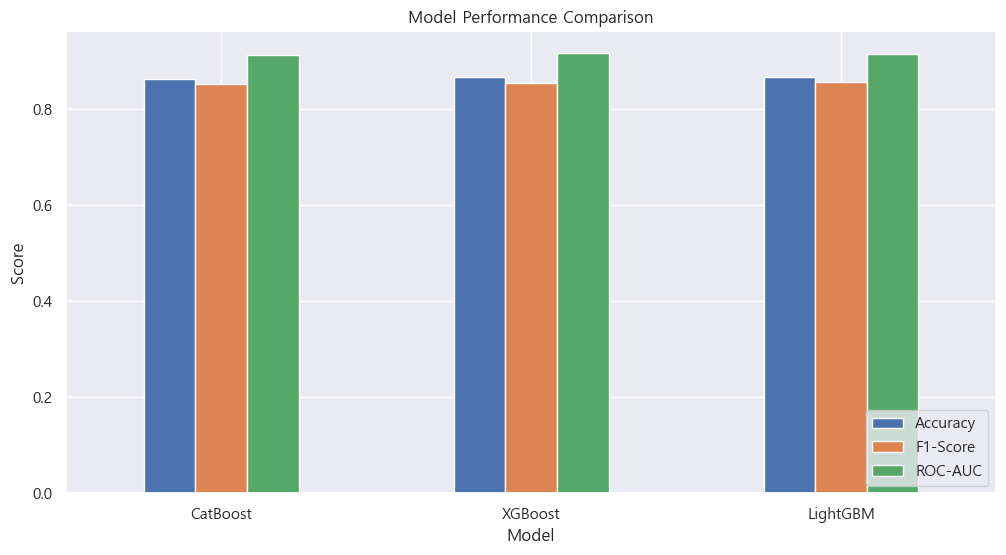

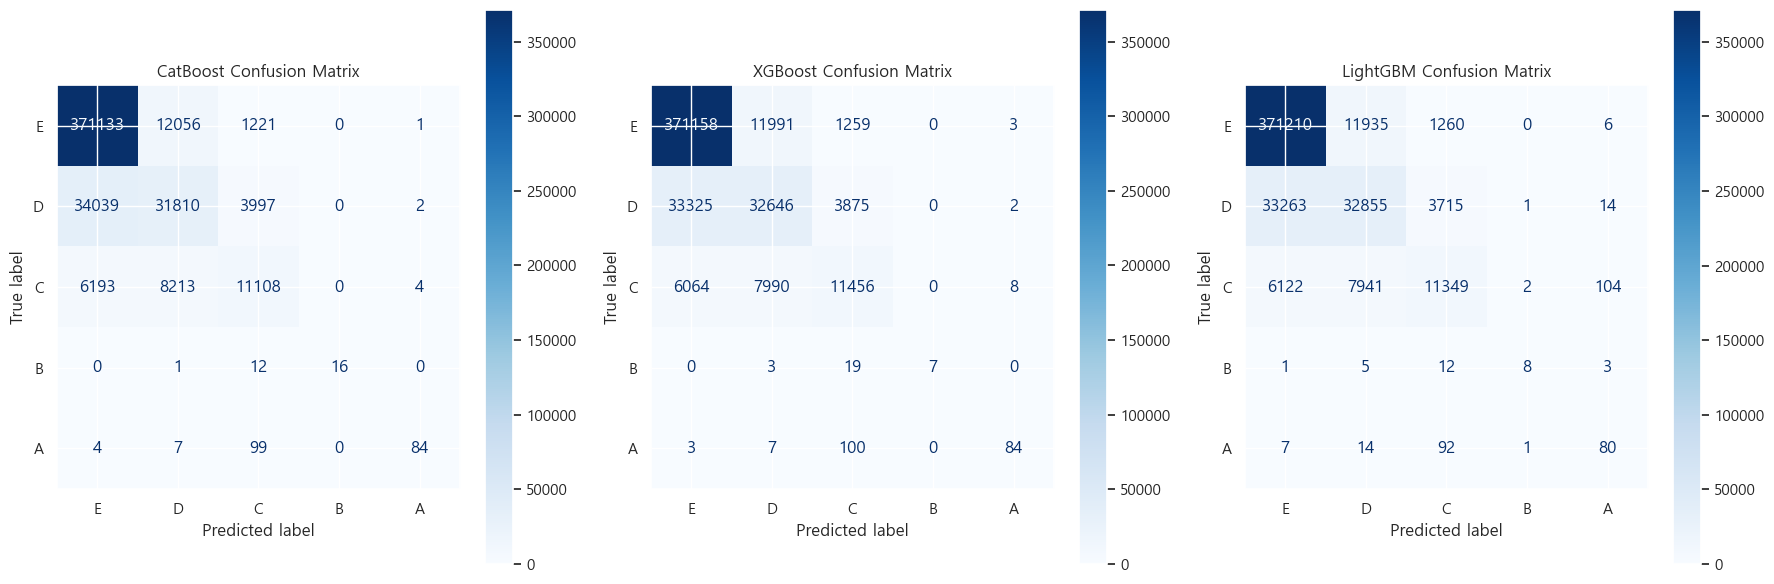

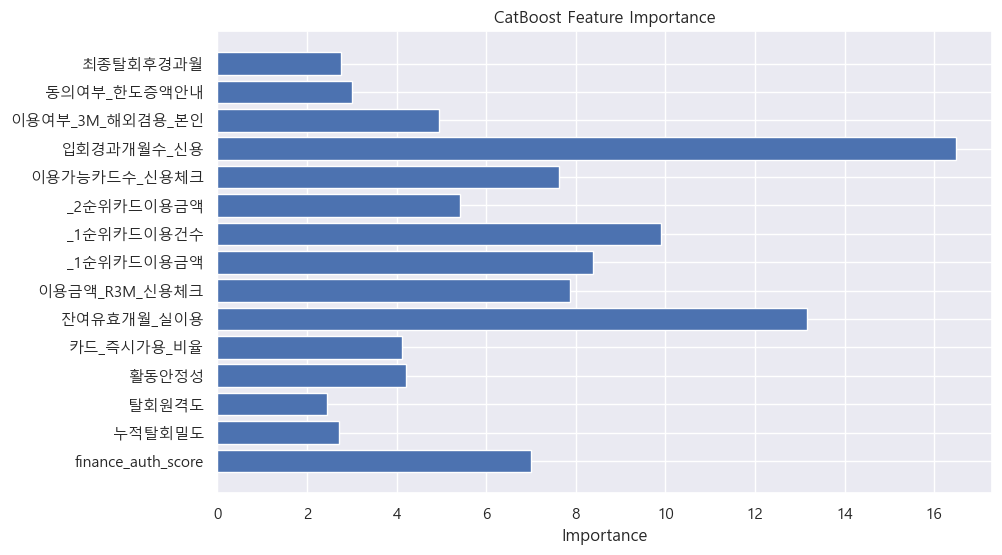

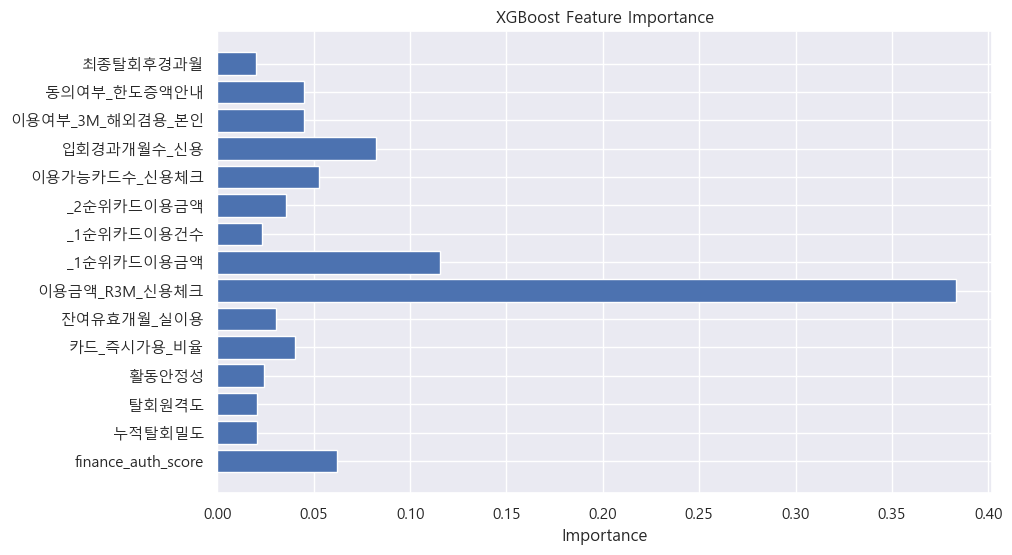

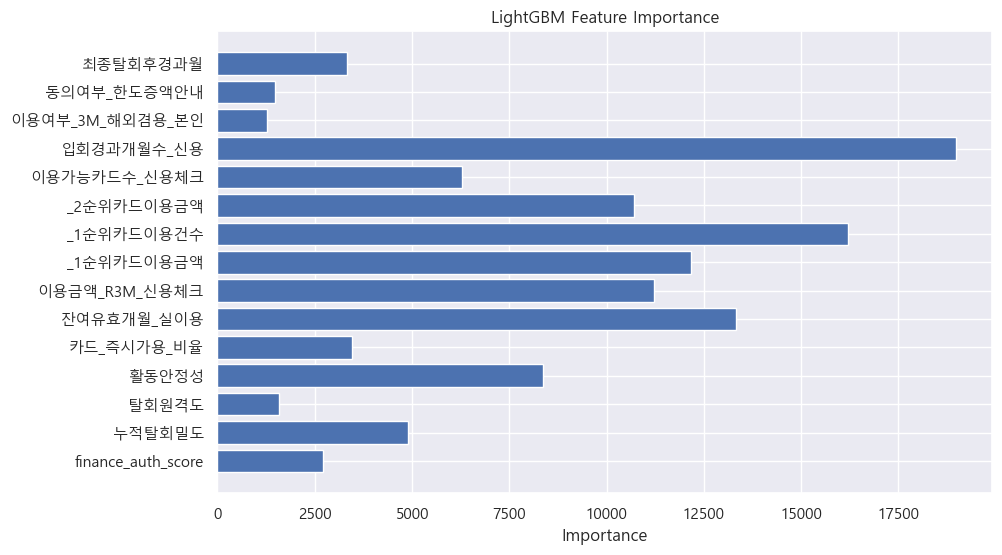

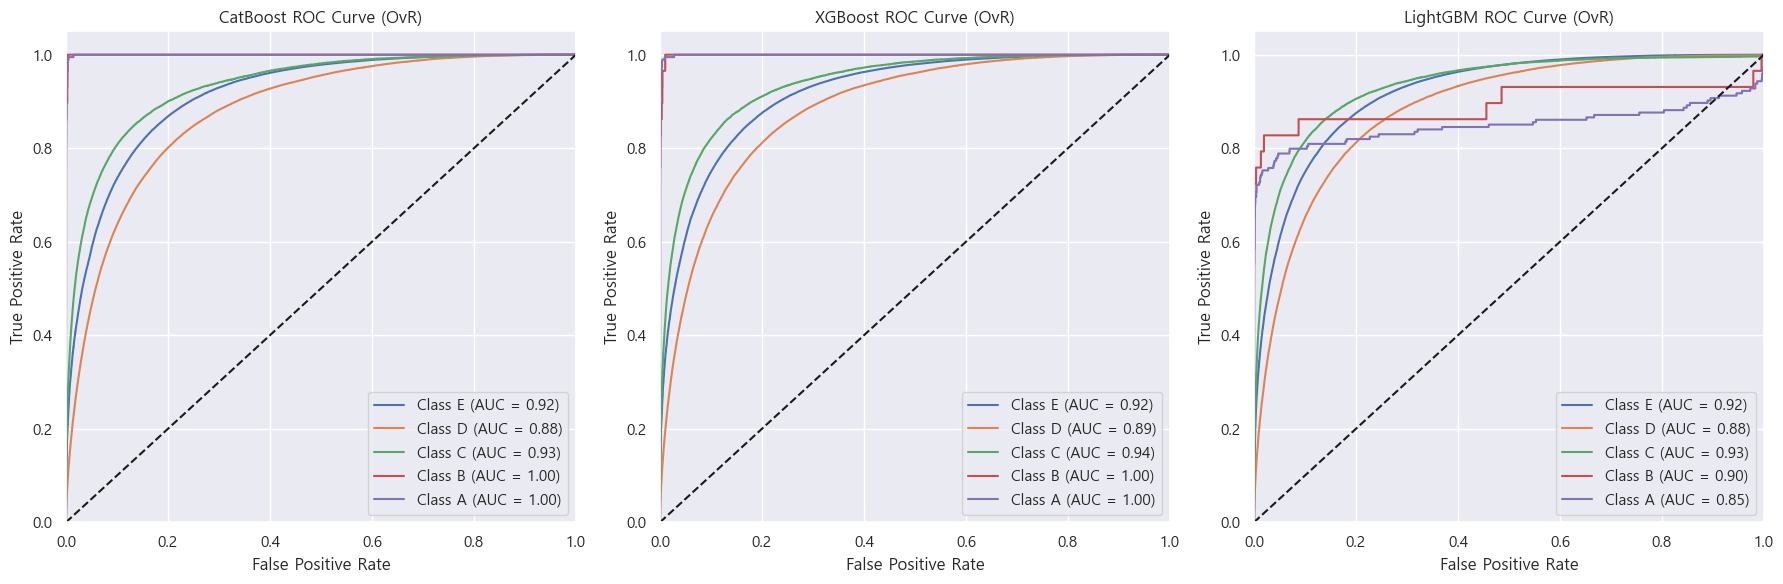


CatBoost Classification Report:
              precision    recall  f1-score   support

           E       0.90      0.97      0.93    384411
           D       0.61      0.46      0.52     69848
           C       0.68      0.44      0.53     25518
           B       1.00      0.55      0.71        29
           A       0.92      0.43      0.59       194

    accuracy                           0.86    480000
   macro avg       0.82      0.57      0.66    480000
weighted avg       0.85      0.86      0.85    480000


XGBoost Classification Report:
              precision    recall  f1-score   support

           E       0.90      0.97      0.93    384411
           D       0.62      0.47      0.53     69848
           C       0.69      0.45      0.54     25518
           B       1.00      0.24      0.39        29
           A       0.87      0.43      0.58       194

    accuracy                           0.87    480000
   macro avg       0.82      0.51      0.60    480000
weighted avg

In [79]:
# Optuna 튜닝된 모델로 최종 학습 및 예측
# CatBoost 최적 모델
best_cat_params = study_cat.best_params
best_cat_params['verbose'] = 0
best_cat_params['task_type'] = 'GPU'
best_cat_params['devices'] = '0'
cat_model_best = CatBoostClassifier(**best_cat_params)
cat_model_best.fit(X_train, y_train)
cat_pred_best = cat_model_best.predict(X_test)
cat_proba_best = cat_model_best.predict_proba(X_test)

# XGBoost 최적 모델
best_xgb_params = study_xgb.best_params
xgb_model_best = XGBClassifier(**best_xgb_params)
xgb_model_best.fit(X_train, y_train)
xgb_pred_best = xgb_model_best.predict(X_test)
xgb_proba_best = xgb_model_best.predict_proba(X_test)

# LightGBM 최적 모델
best_lgb_params = study_lgb.best_params
lgb_model_best = LGBMClassifier(**best_lgb_params)
lgb_model_best.fit(X_train, y_train)
lgb_pred_best = lgb_model_best.predict(X_test)
lgb_proba_best = lgb_model_best.predict_proba(X_test)

# 성능 메트릭 계산
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

models = ['CatBoost', 'XGBoost', 'LightGBM']
predictions = [cat_pred_best, xgb_pred_best, lgb_pred_best]
probas = [cat_proba_best, xgb_proba_best, lgb_proba_best]

accuracy_scores = [accuracy_score(y_test, pred) for pred in predictions]
f1_scores = [f1_score(y_test, pred, average='weighted') for pred in predictions]

# ROC AUC (다중 클래스용 OvR)
roc_auc_scores = []
for proba in probas:
    try:
        roc_auc = roc_auc_score(y_test, proba, multi_class='ovr', average='weighted')
        roc_auc_scores.append(roc_auc)
    except:
        roc_auc_scores.append(np.nan)

# 성능 비교 테이블
import pandas as pd
performance_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy_scores,
    'F1-Score': f1_scores,
    'ROC-AUC': roc_auc_scores
})
print("성능 비교 테이블:")
print(performance_df)

# 바 차트로 성능 비교
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
performance_df.set_index('Model').plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix 시각화
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, (model, pred) in enumerate(zip(models, predictions)):
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['E', 'D', 'C', 'B', 'A'])
    disp.plot(ax=axes[i], cmap='Blues')
    axes[i].set_title(f'{model} Confusion Matrix')
plt.tight_layout()
plt.show()

# Feature Importance 시각화
# CatBoost
cat_importance = cat_model_best.get_feature_importance()
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, cat_importance)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.show()

# XGBoost
xgb_importance = xgb_model_best.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, xgb_importance)
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.show()

# LightGBM
lgb_importance = lgb_model_best.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, lgb_importance)
plt.title('LightGBM Feature Importance')
plt.xlabel('Importance')
plt.show()

# ROC Curve (다중 클래스용 OvR)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])  # E=0, D=1, C=2, B=3, A=4

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, (model, proba) in enumerate(zip(models, probas)):
    for j in range(5):
        fpr, tpr, _ = roc_curve(y_test_bin[:, j], proba[:, j])
        roc_auc = auc(fpr, tpr)
        axes[i].plot(fpr, tpr, label=f'Class {["E","D","C","B","A"][j]} (AUC = {roc_auc:.2f})')
    axes[i].plot([0, 1], [0, 1], 'k--')
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'{model} ROC Curve (OvR)')
    axes[i].legend(loc="lower right")
plt.tight_layout()
plt.show()

# Classification Report 출력
for model, pred in zip(models, predictions):
    print(f"\n{model} Classification Report:")
    print(classification_report(y_test, pred, target_names=['E', 'D', 'C', 'B', 'A']))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_20040\818881230.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, y='Feature', x='Importance', palette='viridis')


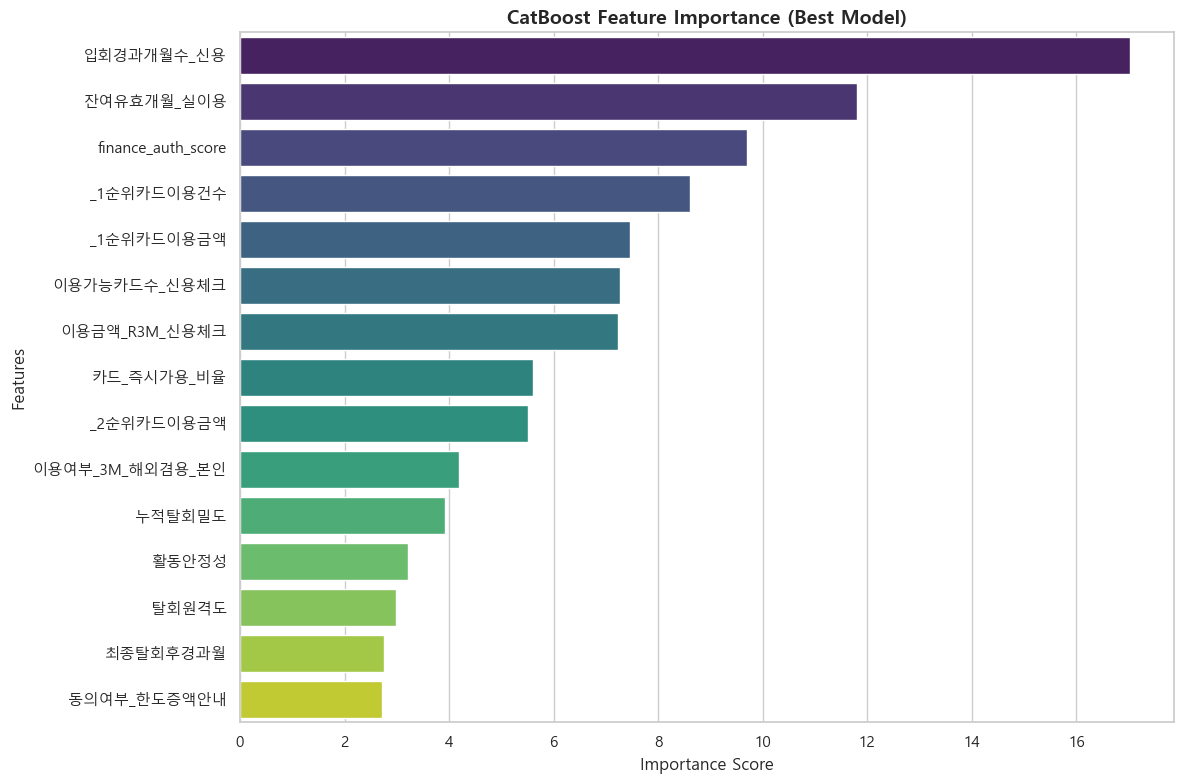


=== Top 10 Most Important Features ===
               Feature  Importance
11          입회경과개월수_신용   17.016611
5           잔여유효개월_실이용   11.797493
0   finance_auth_score    9.695501
8           _1순위카드이용건수    8.611793
7           _1순위카드이용금액    7.458821
10        이용가능카드수_신용체크    7.276959
6        이용금액_R3M_신용체크    7.234805
4           카드_즉시가용_비율    5.614338
9           _2순위카드이용금액    5.507927
12     이용여부_3M_해외겸용_본인    4.197344


In [106]:
# Best 모델에서 Feature Importance 시각화 (재학습 불필요 - 이미 위에서 저장됨)
# Feature Importance 추출
feature_importance = best_model.get_feature_importance()
feature_names = X_train.columns

# DataFrame으로 변환
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Seaborn으로 시각화
plt.figure(figsize=(12, 8))
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

sns.barplot(data=importance_df, y='Feature', x='Importance', palette='viridis')
plt.title('CatBoost Feature Importance (Best Model)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

# Top 20 Feature 시각화 (Feature가 많을 경우)
if len(importance_df) > 20:
    plt.figure(figsize=(12, 8))
    sns.barplot(data=importance_df.head(20), y='Feature', x='Importance', palette='rocket')
    plt.title('CatBoost Top 20 Feature Importance (Best Model)', fontsize=14, fontweight='bold')
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.tight_layout()
    plt.show()

# 상위 10개 Feature 출력
print("\n=== Top 10 Most Important Features ===")
print(importance_df.head(10))